## Base

In [5]:
# ---------------------------------------------------------------------------
# PARTE 1: CLASES FUNDAMENTALES Y DE SIMULACIÓN
# ---------------------------------------------------------------------------

# Importaciones generales
import numpy as np
import pandas as pd
from scipy.stats import t
import matplotlib.pyplot as plt
from tqdm import tqdm
from scipy import stats
import seaborn as sns

# Importaciones específicas de modelos
from statsmodels.tsa.ar_model import AutoReg
from sklearn.linear_model import Ridge
from bayes_opt import BayesianOptimization
from sklearn.utils import check_random_state
from scipy.linalg import toeplitz
import torch
import torch.nn as nn
import torch.optim as optim

# Importación de las métricas desde un archivo externo, como se solicitó.
from metrica import crps, ecrps


class ARMASimulation:
    """
    Genera series temporales ARMA con diferentes tipos de ruido.
    También implementa el Sieve Bootstrap para generar la distribución de referencia.
    """
    def __init__(self, model_type='AR(1)', phi=[], theta=[], noise_dist='normal', sigma=1.0, seed=None):
        self.model_type = model_type
        self.phi = np.array(phi)
        self.theta = np.array(theta)
        self.noise_dist = noise_dist
        self.sigma = sigma
        self.seed = seed
        self.rng = np.random.default_rng(seed)
        self.series = None
        self.residuals = None

    def model_params(self):
        """Devuelve los parámetros del modelo en un diccionario."""
        return {'model_type': self.model_type, 'phi': self.phi.tolist(), 'theta': self.theta.tolist(), 'sigma': self.sigma}

    def simulate(self, n=250, burn_in=50):
        """Simula una serie temporal ARMA."""
        total_length = n + burn_in
        errors = self._generate_errors(total_length + 1)
        p, q = len(self.phi), len(self.theta)
        series = np.zeros(total_length)
        series[:max(p,q)] = self.rng.normal(0, self.sigma, max(p,q))

        for t in range(max(p,q), total_length):
            ar_part = np.dot(self.phi, series[t-p:t][::-1]) if p > 0 else 0
            ma_part = np.dot(self.theta, errors[t-q:t][::-1]) if q > 0 else 0
            series[t] = ar_part + errors[t] + ma_part
            
        self.series = series[burn_in:]
        return self.series
    
    def _generate_errors(self, n):
        """Genera el término de error según la distribución especificada."""
        if self.noise_dist == 'normal':
            return self.rng.normal(0, self.sigma, n)
        if self.noise_dist == 'uniform':
            return self.rng.uniform(-np.sqrt(3)*self.sigma, np.sqrt(3)*self.sigma, size=n)
        if self.noise_dist == 'exponential':
            return self.rng.exponential(scale=self.sigma, size=n) - self.sigma
        if self.noise_dist == 't-student':
            df_value = 18 * self.sigma**2 / (9 * self.sigma**2 - 1) + 1 if (9*self.sigma**2 - 1) > 0 else 5
            df = max(int(df_value), 3)
            scale_factor = self.sigma / np.sqrt(df / (df - 2)) if df > 2 else self.sigma
            return t.rvs(df, scale=scale_factor, size=n, random_state=self.rng)
        elif self.noise_dist == 'mixture':
            n1, n2 = int(n * 0.75), n - int(n * 0.75)
            variance_of_means = 0.75 * (-0.25)**2 + 0.25 * (0.75)**2
            component_std = np.sqrt(self.sigma**2 - variance_of_means) if self.sigma**2 > variance_of_means else 0
            comp1 = self.rng.normal(-0.25, component_std, size=n1)
            comp2 = self.rng.normal(0.75, component_std, size=n2)
            mixture = np.concatenate([comp1, comp2])
            self.rng.shuffle(mixture)
            return mixture
        else:
            raise ValueError("Distribución de ruido no soportada")

    def sieve_bootstrap(self, n_bootstrap=1000, p_order=2, h=1):
        """Implementa el Sieve Bootstrap para obtener una distribución de referencia."""
        if self.series is None: raise ValueError("Primero simule la serie")
        n = len(self.series)
        X = self.series - np.mean(self.series)
        
        # Estimación Yule-Walker para el modelo AR(p_order) de aproximación
        r = [np.mean(X[k:] * X[:n - k]) if k < n else 0 for k in range(p_order + 1)]
        R, rho = toeplitz(r[:p_order]), r[1:p_order + 1]
        try:
            phi_hat = np.linalg.solve(R, rho)
        except np.linalg.LinAlgError:
            phi_hat = np.linalg.pinv(R) @ rho
        
        # Calcular residuos del modelo AR ajustado
        residuals = [X[t] - np.dot(phi_hat, X[t-p_order:t][::-1]) for t in range(p_order, n)]
        self.residuals = np.array(residuals) - np.mean(residuals)
        
        # Generar muestras bootstrap a partir de los residuos
        bootstrap_samples = []
        for _ in range(n_bootstrap):
            eps_star = self.rng.choice(self.residuals, size=n + h, replace=True)
            X_star = np.zeros(n + h)
            X_star[:p_order] = X[:p_order]
            for t in range(p_order, n + h):
                X_star[t] = np.dot(phi_hat, X_star[t - p_order:t][::-1]) + eps_star[t]
            bootstrap_samples.append(X_star[-h:])
        return bootstrap_samples

class PlotManager:
    """Clase de utilidad para generar los gráficos del análisis."""
    _STYLE = {'figsize': (14, 6), 'grid_style': {'alpha': 0.3, 'linestyle': ':'},
              'default_colors': ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f']}

    @classmethod
    def _base_plot(cls, title, xlabel, ylabel):
        """Crea la base para un gráfico estándar."""
        plt.figure(figsize=cls._STYLE['figsize'])
        plt.title(title, fontsize=14, pad=15)
        plt.xlabel(xlabel, fontsize=12)
        plt.ylabel(ylabel, fontsize=12)
        plt.grid(**cls._STYLE['grid_style'])
        plt.gca().spines[['top', 'right']].set_visible(False)

    @classmethod
    def plot_density_comparison(cls, distributions, metric_values, colors=None):
        """Compara las densidades de las distribuciones predictivas."""
        cls._base_plot("Comparación de Densidades Predictivas (vs Sieve)", "Valor", "Densidad")
        if colors is None:
            colors = {name: cls._STYLE['default_colors'][i] for i, name in enumerate(distributions.keys())}
        
        for name, data in distributions.items():
            color = colors.get(name)
            linestyle = '-' if name == 'Sieve Bootstrap' else '--'
            if color is None:
                raise ValueError(f"Color no definido para {name}.")
            
            clean_data = data[np.isfinite(data)]
            if len(clean_data) > 1:
                sns.kdeplot(clean_data, color=color, label=name, linestyle=linestyle, linewidth=2, warn_singular=False)
        
        sorted_metrics = sorted(metric_values.items(), key=lambda x: x[1])
        metrics_text = "\n".join([f"{k}: {v:.4f}" for k, v in sorted_metrics])
        plt.text(0.95, 0.95, f'ECRPS vs Sieve:\n{metrics_text}', transform=plt.gca().transAxes,
                 verticalalignment='top', horizontalalignment='right', bbox=dict(facecolor='white', alpha=0.9, edgecolor='gray'))
        
        plt.legend(loc='upper left', frameon=True)
        plt.tight_layout()
        plt.show()

# ---------------------------------------------------------------------------
# PARTE 2: LAS CLASES DE MODELOS PREDICTIVOS (CORREGIDA)
# ---------------------------------------------------------------------------

class EnhancedBootstrappingModel:
    """Modelo con Block Bootstrap y evaluación CRPS."""
    def __init__(self, arma_simulator, random_state=42, verbose=False):
        self.n_lags, self.random_state, self.verbose = None, random_state, verbose
        self.rng = np.random.default_rng(self.random_state)
        self.arma_simulator = arma_simulator
        self.train, self.test, self.mean_val, self.std_val = None, None, None, None

    def prepare_data(self, series):
        split_idx = int(len(series)*0.9)
        self.train, self.test = series[:split_idx], series[split_idx:]
        self.mean_val, self.std_val = np.mean(self.train), np.std(self.train)
        return (self.train - self.mean_val) / (self.std_val + 1e-8)

    def denormalize(self, values): return (values * self.std_val) + self.mean_val

    def _block_bootstrap_predict(self, fitted_model, n_boot):
        residuals, n_resid = fitted_model.resid, len(fitted_model.resid)
        if n_resid < 2: return fitted_model.forecast(steps=1) + self.rng.choice(residuals, size=n_boot, replace=True)
        block_length = max(1, int(n_resid**(1/3)))
        blocks = [residuals[i:i+block_length] for i in range(n_resid - block_length + 1)]
        if not blocks: return fitted_model.forecast(steps=1)
        resampled_indices = self.rng.choice(len(blocks), size=(n_boot // block_length) + 1, replace=True)
        bootstrap_error_pool = np.concatenate([blocks[i] for i in resampled_indices])
        return fitted_model.forecast(steps=1) + self.rng.choice(bootstrap_error_pool, size=n_boot, replace=True)

    def fit_predict(self, data, n_boot=1000):
        normalized_train = self.prepare_data(data)
        test_predictions, current_data = [], normalized_train.copy()
        for _ in range(len(self.test)):
            if len(current_data) <= self.n_lags * 2 + 1:
                pred = self.denormalize(np.mean(current_data))
                test_predictions.append(np.full(n_boot, pred))
                current_data = np.append(current_data, np.mean(current_data))
                continue
            try: fitted_model = AutoReg(current_data, lags=self.n_lags, old_names=False).fit()
            except (np.linalg.LinAlgError, ValueError):
                pred = self.denormalize(np.mean(current_data))
                test_predictions.append(np.full(n_boot, pred))
                current_data = np.append(current_data, np.mean(current_data))
                continue
            boot_preds = self._block_bootstrap_predict(fitted_model, n_boot)
            current_data = np.append(current_data, np.mean(boot_preds))
            test_predictions.append(self.denormalize(boot_preds))
        return test_predictions

    def grid_search(self, lags_range=range(1, 13), n_boot=500):
        best_crps, best_lag = float('inf'), 1
        normalized_train = self.prepare_data(self.arma_simulator.series)
        for n_lags in lags_range:
            self.n_lags = n_lags
            if len(normalized_train) <= n_lags + 10: continue
            crps_values = []
            try:
                for t in range(n_lags + 10, len(normalized_train)):
                    train_subset = normalized_train[:t]
                    if len(train_subset) <= 2 * n_lags + 1: continue
                    try: fitted_model = AutoReg(train_subset, lags=n_lags, old_names=False).fit()
                    except (np.linalg.LinAlgError, ValueError): continue
                    boot_preds = self._block_bootstrap_predict(fitted_model, n_boot)
                    crps_values.append(crps(boot_preds, normalized_train[t]))
                if crps_values and (avg_crps := np.nanmean(crps_values)) < best_crps:
                    best_crps, best_lag = avg_crps, n_lags
            except Exception: continue
        self.n_lags = best_lag
        if self.verbose: print(f"✅ Mejor n_lags (Block Bootstrap): {best_lag} (CRPS: {best_crps:.4f})")
        return best_lag, best_crps

class LSPM:
    """Least Squares Prediction Machine (LSPM) - Versión Studentized."""
    def __init__(self, random_state=42, verbose=False):
        self.version, self.random_state, self.verbose = 'studentized', random_state, verbose
        self.rng, self.n_lags = np.random.default_rng(random_state), None

    def optimize_hyperparameters(self, df, reference_noise):
        if self.verbose: print(f"✅ Opt. LSPM: Usando '{self.version}'. No se requiere optimización.")
        return None, -1.0
    
    def _calculate_critical_values(self, df):
        values = df['valor'].values if isinstance(df, pd.DataFrame) else np.asarray(df)
        p = self.n_lags if self.n_lags and self.n_lags > 0 else max(1, int(len(values)**(1/3)))
        if len(values) < 2 * p + 2: return []
        y_full, X_full = values[p:], np.array([values[i:i+p] for i in range(len(values) - p)])
        X_train, y_train, x_test, n = X_full[:-1], y_full[:-1], X_full[-1], len(X_full)
        X_train_b, x_test_b = np.c_[np.ones(n - 1), X_train], np.r_[1, x_test]
        X_bar = np.vstack([X_train_b, x_test_b])
        try: H_bar = X_bar @ np.linalg.pinv(X_bar.T @ X_bar) @ X_bar.T
        except np.linalg.LinAlgError: return []
        
        # --- CORRECCIÓN DEL UnboundLocalError ---
        # 1. Asignar h_ii primero
        h_ii = np.diag(H_bar)
        # 2. Luego usar h_ii para asignar las demás variables
        h_n_vec, h_in_vec, h_n = H_bar[-1, :-1], H_bar[:-1, -1], h_ii[-1]
        # ----------------------------------------
        
        critical_values = []
        for i in range(n - 1):
            h_i = h_ii[i]
            if 1 - h_n < 1e-8 or 1 - h_i < 1e-8: continue
            B_i = np.sqrt(1 - h_n) + h_in_vec[i] / np.sqrt(1 - h_i)
            term1 = np.dot(h_n_vec, y_train) / np.sqrt(1 - h_n)
            term2 = (y_train[i] - np.dot(H_bar[i, :-1], y_train)) / np.sqrt(1 - h_i)
            if abs(B_i) > 1e-8: critical_values.append((term1 + term2) / B_i)
        return critical_values

    def fit_predict(self, df):
        critical_values = self._calculate_critical_values(df)
        if not critical_values:
            mean_pred = np.mean(df['valor'].values if isinstance(df, pd.DataFrame) else df)
            return [{'value': mean_pred, 'probability': 1.0}]
        counts = pd.Series(critical_values).value_counts(normalize=True)
        return [{'value': val, 'probability': prob} for val, prob in counts.items()]

class LSPMW(LSPM):
    """LSPM Ponderado para robustez ante deriva de distribución."""
    def __init__(self, rho=0.95, **kwargs):
        super().__init__(**kwargs)
        self.rho, self.best_params = rho, {'rho': rho}

    def optimize_hyperparameters(self, df, reference_noise):
        def objective(rho):
            try:
                self.rho = np.clip(rho, 0.5, 0.999)
                dist = self.fit_predict(df)
                if not dist: return -1e10
                values, probs = [d['value'] for d in dist], [d['probability'] for d in dist]
                samples = self.rng.choice(values, size=1000, p=probs, replace=True)
                return -ecrps(samples, reference_noise)
            except Exception: return -1e10
        optimizer = BayesianOptimization(f=objective, pbounds={'rho': (0.7, 0.999)}, random_state=self.random_state, verbose=0)
        try: optimizer.maximize(init_points=5, n_iter=10)
        except Exception: pass
        if optimizer.max and optimizer.max['target'] > -1e9:
            self.rho, best_ecrps = optimizer.max['params']['rho'], -optimizer.max['target']
            self.best_params = {'rho': self.rho}
        else: self.rho, best_ecrps = 0.95, -1
        if self.verbose: print(f"✅ Opt. LSPMW: Rho={self.rho:.3f}, ECRPS={best_ecrps:.4f}")
        return self.rho, best_ecrps

    def fit_predict(self, df):
        critical_values = self._calculate_critical_values(df)
        if not critical_values: return super().fit_predict(df)
        weights = self.rho ** np.arange(len(critical_values) - 1, -1, -1)
        dist_df = pd.DataFrame({'value': critical_values, 'weight': weights})
        weighted_dist = dist_df.groupby('value')['weight'].sum()
        weighted_dist /= weighted_dist.sum()
        return [{'value': val, 'probability': prob} for val, prob in weighted_dist.items()]

class LSPM_Hybrid:
    """Modelo de ensamble que combina LSPM y LSPMW para mayor robustez."""
    def __init__(self, random_state=42, verbose=False):
        self.verbose = verbose
        self.experts = {
            'stationary': LSPM(random_state=random_state, verbose=False),
            'fast_drift': LSPMW(rho=0.90, random_state=random_state, verbose=False),
            'slow_drift': LSPMW(random_state=random_state, rho=0.99, verbose=False)
        }
        self.weights = {name: 1.0 / len(self.experts) for name in self.experts}

    def set_lags(self, n_lags):
        """Asigna el mismo número de lags a todos los expertos."""
        for expert in self.experts.values(): expert.n_lags = n_lags
    
    def optimize_hyperparameters(self, df, reference_noise):
        if self.verbose: print(f"✅ Opt. LSPM_Hybrid: No se optimizan hiperparámetros, el ensamble se adapta.")
        return None, -1.0

    def fit_predict(self, df):
        expert_distributions = {name: expert.fit_predict(df) for name, expert in self.experts.items()}
        combined_dist = {}
        for name, dist in expert_distributions.items():
            for point in dist:
                value, prob = point['value'], point['probability']
                if value not in combined_dist: combined_dist[value] = 0.0
                combined_dist[value] += self.weights[name] * prob
        return [{'value': val, 'probability': prob} for val, prob in combined_dist.items()]

class AR_CPS:
    """Autoregressive Conformal Predictive System."""
    def __init__(self, n_lags=5, rho=0.95, alpha=0.1, poly_degree=2, random_state=42, verbose=False):
        self.n_lags, self.rho, self.alpha, self.poly_degree = n_lags, rho, alpha, poly_degree
        self.mean_val, self.std_val, self.random_state, self.verbose = None, None, random_state, verbose
        self.rng = check_random_state(random_state)
        np.random.seed(random_state)

    def optimize_hyperparameters(self, df, reference_noise):
        def objective(n_lags, rho, poly_degree):
            try:
                self.n_lags, self.rho, self.poly_degree = max(1, int(round(n_lags))), min(0.999, max(0.5, float(rho))), max(1, int(round(poly_degree)))
                if len(df) < self.n_lags * 2: return -1e12
                dist = self.fit_predict(df)
                if not dist: return -1e12
                values, probs = np.array([d['value'] for d in dist]), np.array([d['probability'] for d in dist])
                if probs.sum() <= 0: return -1e12
                samples = self.rng.choice(values, size=1000, p=probs / probs.sum())
                return -ecrps(samples, reference_noise)
            except Exception: return -1e12
        optimizer = BayesianOptimization(f=objective, pbounds={'n_lags': (1, 8), 'rho': (0.6, 0.99), 'poly_degree': (1, 3)}, random_state=self.random_state, allow_duplicate_points=True, verbose=0)
        try: optimizer.maximize(init_points=5, n_iter=10)
        except Exception: pass
        if optimizer.max and optimizer.max['target'] > -1e11:
            best, best_ecrps = optimizer.max['params'], -optimizer.max['target']
            self.n_lags, self.rho, self.poly_degree = int(round(best['n_lags'])), best['rho'], int(round(best['poly_degree']))
        else: self.n_lags, self.rho, self.poly_degree, best_ecrps = 3, 0.85, 2, -1
        if self.verbose: print(f"✅ Opt. AR_CPS: Lags={self.n_lags}, Rho={self.rho:.3f}, Pol={self.poly_degree}, ECRPS={best_ecrps:.4f}")
        return self.n_lags, self.rho, self.poly_degree, best_ecrps
        
    def _create_lag_matrix(self, values, n_lags, degree=2):
        n = len(values) - n_lags
        if n <= 0: return np.array([]), np.array([])
        y, X_list = values[n_lags:], [np.ones((n, 1))]
        for lag in range(n_lags):
            lagged = values[lag:lag + n].reshape(-1, 1)
            for d in range(1, degree + 1): X_list.append(np.power(lagged, d))
        return np.hstack(X_list), y

    def _Qn_distribution(self, C):
        sorted_C, n, distribution = np.sort(C), len(C), []
        for i in range(n):
            denorm = (sorted_C[i] * self.std_val) + self.mean_val
            lower, upper = i / (n + 1), (i + 1) / (n + 1)
            if i > 0 and np.isclose(sorted_C[i], sorted_C[i-1]):
                distribution[-1]['probability'], distribution[-1]['upper'] = upper - distribution[-1]['lower'], upper
            else:
                distribution.append({'value': denorm, 'lower': lower, 'upper': upper, 'probability': upper - lower})
        return distribution

    def fit_predict(self, df):
        try:
            values = df['valor'].values if isinstance(df, pd.DataFrame) else np.asarray(df)
            if len(values) < self.n_lags * 2: return []
            self.mean_val, self.std_val = np.nanmean(values), np.nanstd(values) + 1e-8
            normalized = (values - self.mean_val) / self.std_val
            X, y = self._create_lag_matrix(normalized, self.n_lags, self.poly_degree)
            if X.shape[0] == 0: return []
            weights = self.rho ** np.arange(len(y))[::-1]
            model = Ridge(alpha=self.alpha, fit_intercept=False).fit(X, y, sample_weight=weights / (weights.sum() + 1e-8))
            return self._Qn_distribution(model.predict(X))
        except Exception: return []

class DeepARModel:
    def __init__(self, hidden_size=20, n_lags=5, num_layers=1, dropout=0.1, lr=0.01, batch_size=32, epochs=50, num_samples=1000, random_state=42, verbose=False):
        self.hidden_size, self.n_lags, self.num_layers, self.dropout, self.lr, self.batch_size, self.epochs, self.num_samples = hidden_size, n_lags, num_layers, dropout, lr, batch_size, epochs, num_samples
        self.model, self.scaler_mean, self.scaler_std, self.random_state, self.verbose, self.best_params = None, None, None, random_state, verbose, {}
        np.random.seed(random_state), torch.manual_seed(random_state)
    class _DeepARNN(nn.Module):
        def __init__(self, input_size, hidden_size, num_layers, dropout):
            super().__init__(); dropout_to_apply = dropout if num_layers > 1 else 0; self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, dropout=dropout_to_apply); self.fc_mu, self.fc_sigma = nn.Linear(hidden_size, 1), nn.Linear(hidden_size, 1)
        def forward(self, x): lstm_out, _ = self.lstm(x); mu, sigma = self.fc_mu(lstm_out[:, -1, :]), torch.exp(self.fc_sigma(lstm_out[:, -1, :])) + 1e-6; return mu, sigma
    def _create_sequences(self, series):
        X, y = [], []; [X.append(series[i:i + self.n_lags]) for i in range(len(series) - self.n_lags)]; [y.append(series[i + self.n_lags]) for i in range(len(series) - self.n_lags)]; return np.array(X), np.array(y)
    def optimize_hyperparameters(self, df, reference_noise):
        def objective(n_lags, hidden_size, num_layers, dropout, lr):
            try:
                self.n_lags, self.hidden_size, self.num_layers, self.dropout, self.lr = max(1, int(n_lags)), max(5, int(hidden_size)), max(1, int(num_layers)), min(0.5, max(0.0, dropout)), max(0.0001, lr)
                series = df['valor'].values if isinstance(df, pd.DataFrame) else df
                self.scaler_mean, self.scaler_std = np.nanmean(series), np.nanstd(series) + 1e-8
                normalized_series = (series - self.scaler_mean) / self.scaler_std
                if len(normalized_series) <= self.n_lags: return -float('inf')
                X_train, y_train = self._create_sequences(normalized_series)
                if len(X_train) == 0: return -float('inf')
                mu, sigma = np.nanmean(y_train), np.nanstd(y_train) if np.nanstd(y_train) > 1e-6 else 1e-6
                predictions = (np.random.normal(mu, sigma, self.num_samples) * self.scaler_std + self.scaler_mean)
                return -ecrps(predictions, reference_noise)
            except Exception: return -float('inf')
        optimizer = BayesianOptimization(f=objective, pbounds={'n_lags': (1, 10), 'hidden_size': (5, 30), 'num_layers': (1, 3), 'dropout': (0.0, 0.5), 'lr': (0.001, 0.1)}, random_state=self.random_state, verbose=0)
        try: optimizer.maximize(init_points=3, n_iter=7)
        except Exception: pass
        best_ecrps = -1
        if optimizer.max and optimizer.max['target'] > -float('inf'):
            best_ecrps, self.best_params = -optimizer.max['target'], {k: v for k, v in optimizer.max['params'].items()}
            self.best_params.update({'n_lags': int(self.best_params['n_lags']), 'hidden_size': int(self.best_params['hidden_size']), 'num_layers': int(self.best_params['num_layers'])})
        else: self.best_params = {'n_lags': 5, 'hidden_size': 20, 'num_layers': 1, 'dropout': 0.1, 'lr': 0.01}
        if self.verbose: print(f"✅ Opt. DeepAR (ECRPS: {best_ecrps:.4f}): {self.best_params}")
        return self.best_params, best_ecrps
    def fit_predict(self, df):
        try:
            series = df['valor'].values if isinstance(df, pd.DataFrame) else df
            self.scaler_mean, self.scaler_std = np.nanmean(series), np.nanstd(series) + 1e-8
            normalized_series = (series - self.scaler_mean) / self.scaler_std
            if self.best_params: self.__dict__.update(self.best_params)
            if len(normalized_series) <= self.n_lags: return np.full(self.num_samples, self.scaler_mean)
            X_train, y_train = self._create_sequences(normalized_series)
            if X_train.shape[0] < self.batch_size: return np.full(self.num_samples, self.scaler_mean)
            X_tensor, y_tensor = torch.FloatTensor(X_train.reshape(-1, self.n_lags, 1)), torch.FloatTensor(y_train.reshape(-1, 1))
            self.model = self._DeepARNN(1, self.hidden_size, self.num_layers, self.dropout)
            criterion, optimizer = nn.GaussianNLLLoss(), optim.Adam(self.model.parameters(), lr=self.lr)
            self.model.train()
            for _ in range(self.epochs):
                perm = torch.randperm(X_tensor.size(0))
                for i in range(0, X_tensor.size(0), self.batch_size):
                    idx = perm[i:i + self.batch_size]; mu, sigma = self.model(X_tensor[idx]); loss = criterion(mu, y_tensor[idx], sigma); optimizer.zero_grad(), loss.backward(), optimizer.step()
            self.model.eval()
            with torch.no_grad(): mu, sigma = self.model(torch.FloatTensor(normalized_series[-self.n_lags:].reshape(1, self.n_lags, 1)))
            return np.nan_to_num((np.random.normal(mu.item(), sigma.item(), self.num_samples) * self.scaler_std + self.scaler_mean))
        except Exception: return np.full(self.num_samples, np.nanmean(df))

# ---------------------------------------------------------------------------
# PARTE 3: ORQUESTACIÓN Y EJECUCIÓN DE LA SIMULACIÓN
# ---------------------------------------------------------------------------

class Pipeline:
    """
    Orquesta la ejecución de un único escenario: simulación, entrenamiento,
    predicción y evaluación.
    """
    def __init__(self, model_type='ARMA(1,1)', phi=[0.7], theta=[0.3], sigma=1.2, noise_dist='t-student', n_samples=250, seed=42, verbose=False):
        self.model_type, self.phi, self.theta, self.sigma = model_type, phi, theta, sigma
        self.noise_dist, self.n_samples, self.seed, self.verbose = noise_dist, n_samples, seed, verbose
        self.simulator, self.series, self.train_data, self.sieve_samples_flat, self.resultados = None, None, None, None, {}
        self.models = {}

    def run_simulation(self):
        """Genera los datos para el escenario actual."""
        np.random.seed(self.seed)
        self.simulator = ARMASimulation(model_type=self.model_type, phi=self.phi, theta=self.theta, sigma=self.sigma, noise_dist=self.noise_dist, seed=self.seed)
        self.series = self.simulator.simulate(n=self.n_samples)
        self.train_data = self.series[:int(len(self.series) * 0.9)]
        sieve_samples = self.simulator.sieve_bootstrap(n_bootstrap=1000, p_order=max(len(self.phi), 2), h=1)
        self.sieve_samples_flat = np.concatenate(sieve_samples).flatten()

    def train_and_predict_models(self):
        """Entrena y genera predicciones para todos los modelos definidos."""
        df_train = pd.DataFrame({'valor': self.train_data})
        self.models = { 
            'Block Bootstrapping': EnhancedBootstrappingModel(self.simulator, random_state=self.seed, verbose=self.verbose),
            'LSPM': LSPM(random_state=self.seed, verbose=self.verbose),
            'LSPMW': LSPMW(random_state=self.seed, verbose=self.verbose),
            'LSPM_Hybrid': LSPM_Hybrid(random_state=self.seed, verbose=self.verbose),
            'AR_CPS': AR_CPS(random_state=self.seed, verbose=self.verbose),
            'DeepAR': DeepARModel(random_state=self.seed, verbose=self.verbose, epochs=20) 
        }
        
        self.resultados = {}
        for name, model in self.models.items():
            # Asignar lags para modelos que lo requieran
            if hasattr(model, 'set_lags'): model.set_lags(len(self.phi) if self.phi is not None and len(self.phi) > 0 else 2)
            elif hasattr(model, 'n_lags'): model.n_lags = len(self.phi) if self.phi is not None and len(self.phi) > 0 else 2
            
            # Optimizar hiperparámetros
            if hasattr(model, 'grid_search'): model.grid_search(n_boot=100)
            elif hasattr(model, 'optimize_hyperparameters'): model.optimize_hyperparameters(df_train, self.sieve_samples_flat)
            
            # Obtener predicciones (distribución o muestras)
            prediction_output = model.fit_predict(df_train if name != 'Block Bootstrapping' else self.series)
            
            # Convertir la descripción de la distribución a una muestra para evaluación
            if isinstance(prediction_output, list) and prediction_output and isinstance(prediction_output[0], dict):
                values, probs = [d['value'] for d in prediction_output], [d['probability'] for d in prediction_output]
                probs_sum = sum(probs)
                if abs(probs_sum - 1.0) > 1e-6: probs = [p / probs_sum for p in probs] if probs_sum > 0 else [1/len(probs)] * len(probs)
                self.resultados[name] = self.simulator.rng.choice(values, size=1000, p=probs, replace=True)
            else:
                self.resultados[name] = np.array(prediction_output[0] if name == 'Block Bootstrapping' else prediction_output).flatten()

    def calculate_metrics(self):
        """Calcula el ECRPS para cada modelo contra el Sieve Bootstrap."""
        return {name: ecrps(pred, self.sieve_samples_flat) for name, pred in self.resultados.items()}

    def execute(self, show_results=True):
        """Ejecuta el pipeline completo para un escenario."""
        self.run_simulation()
        self.train_and_predict_models()
        metrics = self.calculate_metrics()
        self.resultados['ecrps_sieve'] = pd.DataFrame(metrics.items(), columns=['Modelo', 'ECRPS'])
        
        if show_results:
            print(f"\n{'='*60}\nResultados: {self.model_type}/{self.noise_dist}/σ={self.sigma:.2f}\n{'='*60}")
            display(self.resultados['ecrps_sieve'].sort_values(by='ECRPS'))
            dist_map = {'Sieve Bootstrap': self.sieve_samples_flat, **self.resultados}; del dist_map['ecrps_sieve']
            color_map = {'Sieve Bootstrap': '#d62728', 'Block Bootstrapping': '#ff7f0e', 'LSPM': '#1f77b4', 'LSPMW': '#e377c2', 'LSPM_Hybrid': '#7f7f7f', 'AR_CPS': '#9467bd', 'DeepAR': '#8c564b'}
            PlotManager.plot_density_comparison(dist_map, metrics, color_map)
        return self.resultados

class ScenarioRunner:
    """
    Ejecuta múltiples escenarios, agrega los resultados y realiza análisis comparativos.
    """
    def __init__(self, seed=420):
        self.seed, self.results = seed, []
        self.models_config = [
            {'model_type': 'AR(1)', 'phi': [0.9], 'theta': []}, {'model_type': 'AR(2)', 'phi': [0.5, -0.3], 'theta': []},
            {'model_type': 'MA(1)', 'phi': [], 'theta': [0.7]}, {'model_type': 'MA(2)', 'phi': [], 'theta': [0.4, 0.2]},
            {'model_type': 'ARMA(1,1)', 'phi': [0.6], 'theta': [0.3]}, {'model_type': 'ARMA(2,2)', 'phi': [0.4, -0.2], 'theta': [0.5, 0.1]}
        ]
        self.distributions, self.variances = ['normal', 'uniform', 'exponential', 't-student', 'mixture'], [0.2, 0.5, 1.0, 3.0]
        self.model_names = ['Block Bootstrapping', 'LSPM', 'LSPMW', 'LSPM_Hybrid', 'AR_CPS', 'DeepAR']

    def _generate_scenarios(self, n_scenarios):
        scenarios, count = [], 0
        for model in self.models_config:
            for dist in self.distributions:
                for var in self.variances:
                    if count < n_scenarios:
                        scenarios.append({**model, 'noise_dist': dist, 'sigma': np.sqrt(var), 'scenario_id': count + 1}); count += 1
        return scenarios

    def _run_single_scenario(self, scenario):
        try:
            pipeline = Pipeline(**{k: v for k, v in scenario.items() if k != 'scenario_id'}, seed=self.seed, verbose=False)
            results = pipeline.execute(show_results=False)
            ecrps_sieve = results['ecrps_sieve'].set_index('Modelo')['ECRPS']
            return {**scenario, 'sigma': scenario['sigma']**2, 'ecrps_sieve': ecrps_sieve}
        except Exception as e:
            print(f"Error en {scenario['scenario_id']} ({scenario['model_type']}, {scenario['noise_dist']}): {e}"); return None

    def run(self, n_scenarios=120):
        self.results = [res for scenario in tqdm(self._generate_scenarios(n_scenarios), desc="Ejecutando escenarios") if (res := self._run_single_scenario(scenario)) is not None]
        return self._create_dfs()

    def _create_dfs(self):
        if not self.results: return pd.DataFrame(), pd.DataFrame()
        all_results = [{'Modelo Generador': f"{res['model_type']}({res['noise_dist']}, σ²={res['sigma']:.1f})", 'Modelo': name, 'ECRPS': res['ecrps_sieve'].get(name, np.nan)} for res in self.results for name in self.model_names]
        df_full = pd.DataFrame(all_results)
        df_sieve = df_full.pivot(index='Modelo Generador', columns='Modelo', values='ECRPS').reset_index()
        df_sieve['Mejor Modelo'] = df_sieve[self.model_names].idxmin(axis=1)
        summary_sieve = df_sieve['Mejor Modelo'].value_counts().reset_index(); summary_sieve.columns = ['Modelo', 'Victorias']
        return df_sieve, summary_sieve
    
    def analyze_lspm_vs_lspmw(self, df_sieve):
        print("\n" + "="*60 + "\nAnálisis Específico: LSPM vs. LSPMW (Ponderado)\n" + "="*60)
        df_compare = df_sieve[['LSPM', 'LSPMW']].copy().dropna()
        victorias_lspm = (df_compare['LSPM'] < df_compare['LSPMW']).sum()
        victorias_lspmw = (df_compare['LSPMW'] < df_compare['LSPM']).sum()
        print(f"Victorias totales de LSPM: {victorias_lspm}")
        print(f"Victorias totales de LSPMW: {victorias_lspmw}")

        df_sieve['Tipo_Modelo'] = df_sieve['Modelo Generador'].str.extract(r'([A-Z]+\(\d,\d\))')
        
        # Corrección del DeprecationWarning de pandas
        victorias_por_modelo = df_sieve.groupby('Tipo_Modelo')[['LSPM', 'LSPMW']].apply(
            lambda g: pd.Series({
                'LSPM_Victorias': (g['LSPM'] < g['LSPMW']).sum(),
                'LSPMW_Victorias': (g['LSPMW'] < g['LSPM']).sum()
            })
        ).fillna(0).astype(int)
        
        print("\nDesglose de victorias por tipo de modelo ARMA:")
        display(victorias_por_modelo[['LSPM_Victorias', 'LSPMW_Victorias']])
        print("\nInterpretación: En escenarios estacionarios (ARMA), LSPM aprovecha toda la historia, siendo muy competitivo.")
        print("LSPMW es teóricamente superior ante deriva, pero en estos escenarios estables, su enfoque en datos")
        print("recientes puede ser una ligera desventaja, resultando en un rendimiento muy parejo.")

    def plot_results(self, df_sieve, summary_sieve):
        df_sieve_melt = df_sieve.melt(id_vars=['Modelo Generador', 'Mejor Modelo'], value_vars=self.model_names, var_name='Modelo', value_name='ECRPS')
        plt.figure(figsize=(16, 7))
        plt.subplot(1, 2, 1); sns.boxplot(data=df_sieve_melt, x='Modelo', y='ECRPS'); plt.title('Distribución de ECRPS (vs Sieve)'); plt.xticks(rotation=45, ha='right'); plt.ylabel('ECRPS'); plt.xlabel('')
        plt.subplot(1, 2, 2); plt.pie(summary_sieve['Victorias'], labels=summary_sieve['Modelo'], autopct='%1.1f%%', startangle=90); plt.title('Distribución de Victorias (vs Sieve)')
        plt.tight_layout(); plt.show()

    def perform_statistical_analysis(self, df_sieve):
        results = []
        all_pairs = [(m1, m2) for i, m1 in enumerate(self.model_names) for m2 in self.model_names[i+1:]]
        for model1, model2 in all_pairs:
            try:
                stat, p_val = stats.wilcoxon(df_sieve[model1].dropna(), df_sieve[model2].dropna())
                results.append({'Comparación': f"{model1} vs {model2}", 'Estadístico W': stat, 'p-valor': p_val})
            except ValueError: continue
        df_tests = pd.DataFrame(results)
        df_tests['Diferencia Significativa (p<0.05)'] = df_tests['p-valor'] < 0.05
        print("\n" + "="*60 + "\nAnálisis Estadístico Grupal (Test de Wilcoxon vs Sieve)\n" + "="*60)
        display(df_tests)
        
    def save_results_to_excel(self, df_sieve, filename="resultados_ecrps_BASE.xlsx"):
        df_to_export = df_sieve.copy()
        df_to_export.rename(columns={'Modelo Generador': 'Escenario'}, inplace=True)
        column_order = ['Escenario', 'Block Bootstrapping', 'LSPM', 'LSPMW', 'LSPM_Hybrid', 'AR_CPS', 'DeepAR']
        existing_columns = [col for col in column_order if col in df_to_export.columns]
        df_to_export = df_to_export[existing_columns]
        df_to_export.to_excel(filename, index=False)
        print(f"\n✅ Resultados guardados en '{filename}'")


✅ Mejor n_lags (Block Bootstrap): 2 (CRPS: 0.3213)
✅ Opt. LSPM: Usando 'studentized'. No se requiere optimización.
✅ Opt. LSPMW: Rho=0.984, ECRPS=1.9159
✅ Opt. LSPM_Hybrid: No se optimizan hiperparámetros, el ensamble se adapta.
✅ Opt. AR_CPS: Lags=8, Rho=0.962, Pol=2, ECRPS=1.0046
✅ Opt. DeepAR (ECRPS: 0.9993): {'dropout': np.float64(0.3204058793628256), 'hidden_size': 29, 'lr': np.float64(0.007143537846370346), 'n_lags': 1, 'num_layers': 2}

Resultados: ARMA(1,1)/t-student/σ=1.20


,Modelo,ECRPS
4,AR_CPS,1.005499
0,Block Bootstrapping,1.194115
5,DeepAR,1.414672
1,LSPM,1.892446
2,LSPMW,1.948835
3,LSPM_Hybrid,2.032925


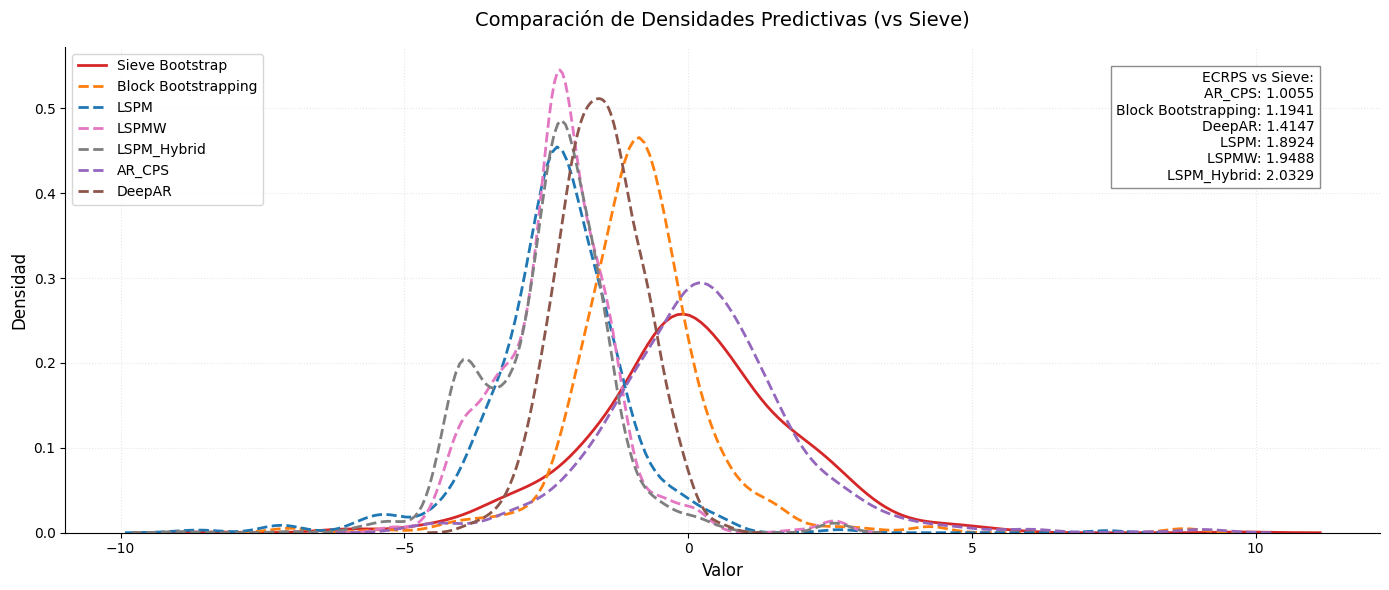


Resultados disponibles en el diccionario:
dict_keys(['Block Bootstrapping', 'LSPM', 'LSPMW', 'LSPM_Hybrid', 'AR_CPS', 'DeepAR', 'ecrps_sieve'])


In [27]:
# 1. Inicializar y ejecutar el pipeline
pipeline = Pipeline(
    model_type='ARMA(1,1)',
    phi=[0.7],
    theta=[0.3],
    sigma=1.2,
    noise_dist='t-student',
    n_samples=1000,
    seed=42,
    verbose=True
)

# 2. Ejecutar todo el flujo
resultados = pipeline.execute(show_results=True)

# 3. Acceder a los resultados directamente si se necesitan
print("\nResultados disponibles en el diccionario:")
print(resultados.keys())

Iniciando la ejecución de los 120 escenarios...


Ejecutando escenarios: 100%|██████████| 120/120 [31:21<00:00, 15.68s/it]


 ANÁLISIS COMPLETO DE LOS 120 ESCENARIOS 

Análisis Específico: LSPM vs. LSPMW (Ponderado)
Victorias totales de LSPM: 64
Victorias totales de LSPMW: 56

Desglose de victorias por tipo de modelo ARMA:


,LSPM_Victorias,LSPMW_Victorias
Tipo_Modelo,,
"ARMA(1,1)",11,9
"ARMA(2,2)",10,10



Interpretación: En escenarios estacionarios (ARMA), LSPM aprovecha toda la historia, siendo muy competitivo.
LSPMW es teóricamente superior ante deriva, pero en estos escenarios estables, su enfoque en datos
recientes puede ser una ligera desventaja, resultando en un rendimiento muy parejo.

Análisis Grupal de Todos los Modelos

🏆 Resumen de Victorias (Mejor Modelo vs Sieve Bootstrap)


,Modelo,Victorias
0,AR_CPS,96
1,LSPM,14
2,LSPMW,6
3,Block Bootstrapping,3
4,DeepAR,1



📊 Generando gráficos de resumen...


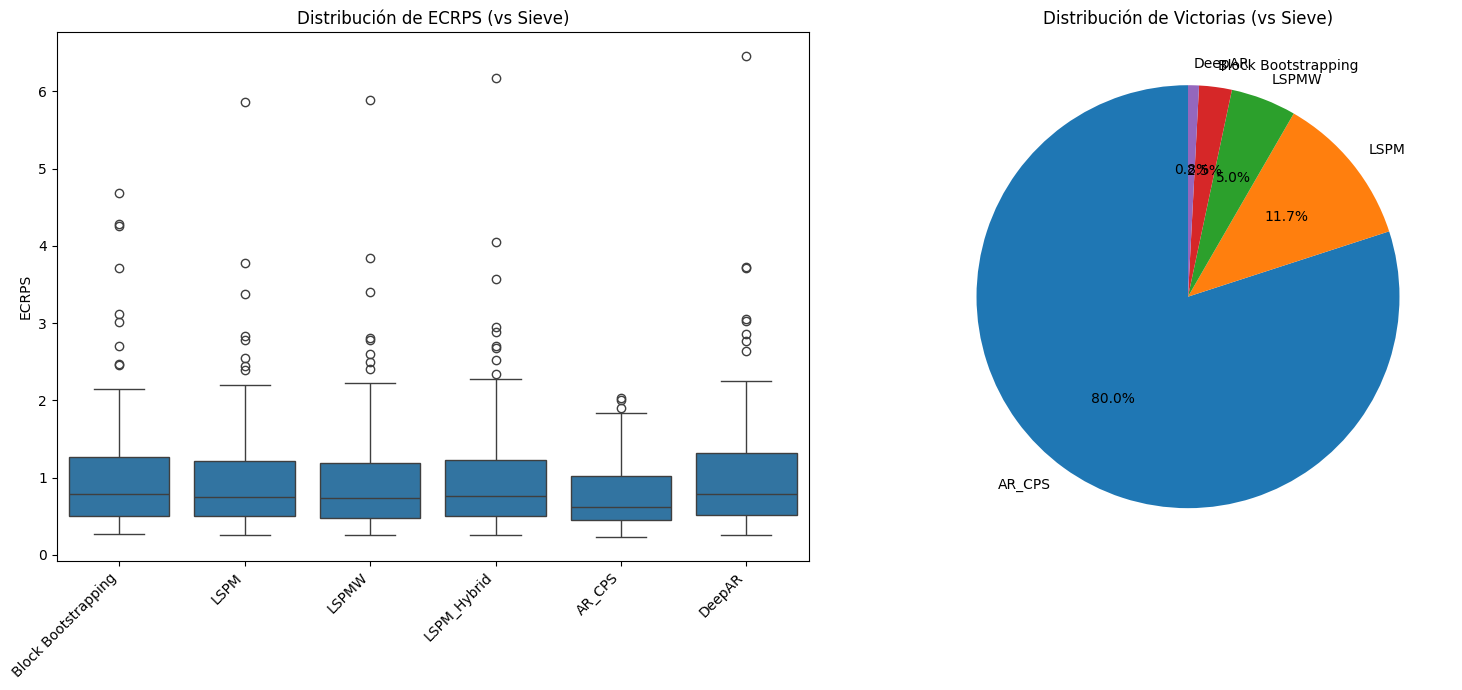


🔬 Realizando análisis estadístico para comparar los modelos...

Análisis Estadístico Grupal (Test de Wilcoxon vs Sieve)


,Comparación,Estadístico W,p-valor,Diferencia Significativa (p<0.05)
0,Block Bootstrapping vs LSPM,1863.0,3.700317e-06,True
1,Block Bootstrapping vs LSPMW,1735.0,6.949953e-07,True
2,Block Bootstrapping vs LSPM_Hybrid,2208.0,1.960662e-04,True
3,Block Bootstrapping vs AR_CPS,14.0,2.802977e-21,True
4,Block Bootstrapping vs DeepAR,3208.0,2.690891e-01,False
5,LSPM vs LSPMW,3560.0,8.545463e-01,False
6,LSPM vs LSPM_Hybrid,499.0,2.410295e-16,True
7,LSPM vs AR_CPS,420.0,4.221761e-17,True
8,LSPM vs DeepAR,1919.0,7.433415e-06,True
9,LSPMW vs LSPM_Hybrid,24.0,3.600426e-21,True



✅ Resultados guardados en 'resultados_ecrps.xlsx'

✅ Ejecución y análisis de todos los escenarios completados.


In [6]:

# =========================================================================================
# Main
# =========================================================================================
try: from IPython.display import display
except ImportError: display = print

if __name__ == '__main__':
    print("Iniciando la ejecución de los 120 escenarios...")
    runner = ScenarioRunner(seed=42)
    df_sieve, summary_sieve = runner.run(n_scenarios=120)

    print("\n" + "="*70 + "\n ANÁLISIS COMPLETO DE LOS 120 ESCENARIOS \n" + "="*70)
    runner.analyze_lspm_vs_lspmw(df_sieve)

    print("\n" + "="*60 + "\nAnálisis Grupal de Todos los Modelos\n" + "="*60)
    print("\n🏆 Resumen de Victorias (Mejor Modelo vs Sieve Bootstrap)")
    display(summary_sieve.sort_values(by='Victorias', ascending=False))
    print("\n📊 Generando gráficos de resumen...")
    runner.plot_results(df_sieve, summary_sieve)
    print("\n🔬 Realizando análisis estadístico para comparar los modelos...")
    runner.perform_statistical_analysis(df_sieve)
    runner.save_results_to_excel(df_sieve, "resultados_ecrps.xlsx")

    print("\n✅ Ejecución y análisis de todos los escenarios completados.")

## LPSMW Hybrid con redes

Iniciando la ejecución de los 120 escenarios...
Esto puede tardar un tiempo considerable.


Ejecutando escenarios: 100%|██████████| 120/120 [38:50<00:00, 19.42s/it]


 ANÁLISIS COMPLETO DE LOS 120 ESCENARIOS 

Análisis Específico: LSPM vs. LSPMW (Ponderado)
Victorias totales de LSPM: 64
Victorias totales de LSPMW: 56

Desglose de victorias por tipo de modelo ARMA:


,LSPM_Victorias,LSPMW_Victorias
Tipo_Modelo,,
"ARMA(1,1)",11,9
"ARMA(2,2)",10,10



Interpretación: En escenarios estacionarios (ARMA), LSPM aprovecha toda la historia, siendo muy competitivo.
LSPMW es teóricamente superior ante deriva, pero en estos escenarios estables, su enfoque en datos
recientes puede ser una ligera desventaja, resultando en un rendimiento muy parejo.

Análisis Grupal de Todos los Modelos

🏆 Resumen de Victorias (Mejor Modelo vs Sieve Bootstrap)


,Modelo,Victorias
0,AR_CPS,96
1,LSPM,14
2,ContextualLSPM,6
3,Block Bootstrapping,3
4,LSPMW,1



📊 Generando gráficos de resumen...


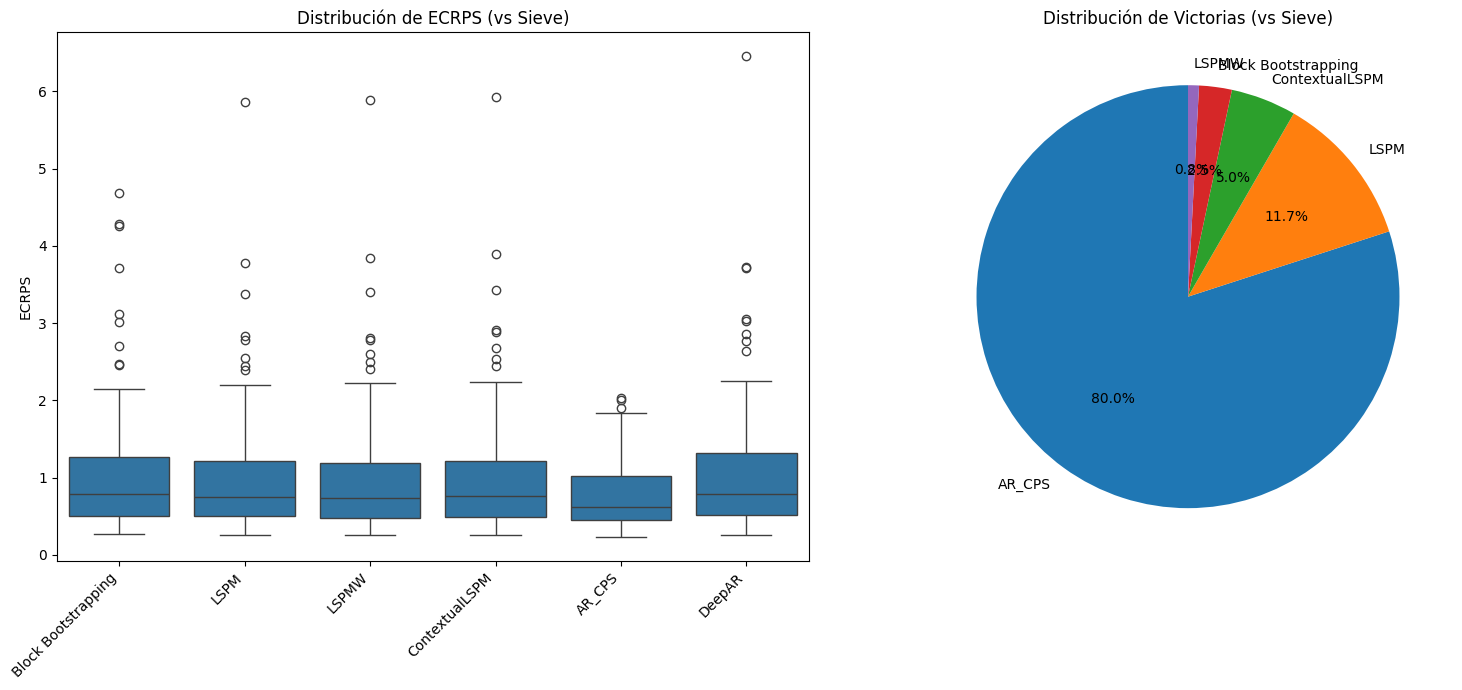


🔬 Realizando análisis estadístico para comparar los modelos...

Análisis Estadístico Grupal (Test de Wilcoxon vs Sieve)


,Comparación,Estadístico W,p-valor,Diferencia Significativa (p<0.05)
0,Block Bootstrapping vs LSPM,1863.0,3.700317e-06,True
1,Block Bootstrapping vs LSPMW,1735.0,6.949953e-07,True
2,Block Bootstrapping vs ContextualLSPM,2141.0,9.639309e-05,True
3,Block Bootstrapping vs AR_CPS,14.0,2.802977e-21,True
4,Block Bootstrapping vs DeepAR,3208.0,2.690891e-01,False
5,LSPM vs LSPMW,3560.0,8.545463e-01,False
6,LSPM vs ContextualLSPM,744.0,4.091372e-14,True
7,LSPM vs AR_CPS,420.0,4.221761e-17,True
8,LSPM vs DeepAR,1919.0,7.433415e-06,True
9,LSPMW vs ContextualLSPM,180.0,1.638550e-19,True



✅ Resultados guardados en 'resultados_ecrps.xlsx'

✅ Ejecución y análisis de todos los escenarios completados.


In [3]:
# ---------------------------------------------------------------------------
# PARTE 1: CLASES FUNDAMENTALES Y DE SIMULACIÓN
# ---------------------------------------------------------------------------

# Importaciones generales
import numpy as np
import pandas as pd
from scipy.stats import t
import matplotlib.pyplot as plt
from tqdm import tqdm
from scipy import stats
import seaborn as sns

# Importaciones específicas de modelos
from statsmodels.tsa.ar_model import AutoReg
from sklearn.linear_model import Ridge, LogisticRegression
from bayes_opt import BayesianOptimization
from sklearn.utils import check_random_state
from scipy.linalg import toeplitz
import torch
import torch.nn as nn
import torch.optim as optim
from metrica import ecrps, crps

class ARMASimulation:
    """
    Genera series temporales ARMA con diferentes tipos de ruido.
    También implementa el Sieve Bootstrap para generar la distribución de referencia.
    """
    def __init__(self, model_type='AR(1)', phi=[], theta=[], noise_dist='normal', sigma=1.0, seed=None):
        self.model_type = model_type
        self.phi = np.array(phi)
        self.theta = np.array(theta)
        self.noise_dist = noise_dist
        self.sigma = sigma
        self.seed = seed
        self.rng = np.random.default_rng(seed)
        self.series = None
        self.residuals = None

    def model_params(self):
        """Devuelve los parámetros del modelo en un diccionario."""
        return {'model_type': self.model_type, 'phi': self.phi.tolist(), 'theta': self.theta.tolist(), 'sigma': self.sigma}

    def simulate(self, n=250, burn_in=50):
        """Simula una serie temporal ARMA."""
        total_length = n + burn_in
        errors = self._generate_errors(total_length + 1)
        p, q = len(self.phi), len(self.theta)
        series = np.zeros(total_length)
        series[:max(p,q)] = self.rng.normal(0, self.sigma, max(p,q))

        for t in range(max(p,q), total_length):
            ar_part = np.dot(self.phi, series[t-p:t][::-1]) if p > 0 else 0
            ma_part = np.dot(self.theta, errors[t-q:t][::-1]) if q > 0 else 0
            series[t] = ar_part + errors[t] + ma_part
            
        self.series = series[burn_in:]
        return self.series
    
    def _generate_errors(self, n):
        """Genera el término de error según la distribución especificada."""
        if self.noise_dist == 'normal': return self.rng.normal(0, self.sigma, n)
        if self.noise_dist == 'uniform': return self.rng.uniform(-np.sqrt(3)*self.sigma, np.sqrt(3)*self.sigma, size=n)
        if self.noise_dist == 'exponential': return self.rng.exponential(scale=self.sigma, size=n) - self.sigma
        if self.noise_dist == 't-student':
            df_value = 18 * self.sigma**2 / (9 * self.sigma**2 - 1) + 1 if (9*self.sigma**2 - 1) > 0 else 5
            df = max(int(df_value), 3)
            scale_factor = self.sigma / np.sqrt(df / (df - 2)) if df > 2 else self.sigma
            return t.rvs(df, scale=scale_factor, size=n, random_state=self.rng)
        elif self.noise_dist == 'mixture':
            n1, n2 = int(n * 0.75), n - int(n * 0.75)
            variance_of_means = 0.75 * (-0.25)**2 + 0.25 * (0.75)**2
            component_std = np.sqrt(self.sigma**2 - variance_of_means) if self.sigma**2 > variance_of_means else 0
            comp1, comp2 = self.rng.normal(-0.25, component_std, size=n1), self.rng.normal(0.75, component_std, size=n2)
            mixture = np.concatenate([comp1, comp2]); self.rng.shuffle(mixture)
            return mixture
        else: raise ValueError("Distribución de ruido no soportada")

    def sieve_bootstrap(self, n_bootstrap=1000, p_order=2, h=1):
        """Implementa el Sieve Bootstrap para obtener una distribución de referencia."""
        if self.series is None: raise ValueError("Primero simule la serie")
        n, X = len(self.series), self.series - np.mean(self.series)
        
        r = [np.mean(X[k:] * X[:n - k]) if k < n else 0 for k in range(p_order + 1)]
        R, rho = toeplitz(r[:p_order]), r[1:p_order + 1]
        try: phi_hat = np.linalg.solve(R, rho)
        except np.linalg.LinAlgError: phi_hat = np.linalg.pinv(R) @ rho
        
        residuals = [X[t] - np.dot(phi_hat, X[t-p_order:t][::-1]) for t in range(p_order, n)]
        self.residuals = np.array(residuals) - np.mean(residuals)
        
        bootstrap_samples = []
        for _ in range(n_bootstrap):
            eps_star, X_star = self.rng.choice(self.residuals, size=n + h, replace=True), np.zeros(n + h)
            X_star[:p_order] = X[:p_order]
            for t in range(p_order, n + h): X_star[t] = np.dot(phi_hat, X_star[t - p_order:t][::-1]) + eps_star[t]
            bootstrap_samples.append(X_star[-h:])
        return bootstrap_samples

class PlotManager:
    """Clase de utilidad para generar los gráficos del análisis."""
    _STYLE = {'figsize': (14, 6), 'grid_style': {'alpha': 0.3, 'linestyle': ':'},
              'default_colors': ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f']}

    @classmethod
    def _base_plot(cls, title, xlabel, ylabel):
        """Crea la base para un gráfico estándar."""
        plt.figure(figsize=cls._STYLE['figsize']); plt.title(title, fontsize=14, pad=15)
        plt.xlabel(xlabel, fontsize=12), plt.ylabel(ylabel, fontsize=12)
        plt.grid(**cls._STYLE['grid_style']); plt.gca().spines[['top', 'right']].set_visible(False)

    @classmethod
    def plot_density_comparison(cls, distributions, metric_values, colors=None):
        """Compara las densidades de las distribuciones predictivas."""
        cls._base_plot("Comparación de Densidades Predictivas (vs Sieve)", "Valor", "Densidad")
        if colors is None: colors = {name: cls._STYLE['default_colors'][i] for i, name in enumerate(distributions.keys())}
        
        for name, data in distributions.items():
            color, linestyle = colors.get(name), '-' if name == 'Sieve Bootstrap' else '--'
            if color is None: raise ValueError(f"Color no definido para {name}.")
            clean_data = data[np.isfinite(data)]
            if len(clean_data) > 1: sns.kdeplot(clean_data, color=color, label=name, linestyle=linestyle, linewidth=2, warn_singular=False)
        
        sorted_metrics = sorted(metric_values.items(), key=lambda x: x[1])
        metrics_text = "\n".join([f"{k}: {v:.4f}" for k, v in sorted_metrics])
        plt.text(0.95, 0.95, f'ECRPS vs Sieve:\n{metrics_text}', transform=plt.gca().transAxes,
                 verticalalignment='top', horizontalalignment='right', bbox=dict(facecolor='white', alpha=0.9, edgecolor='gray'))
        
        plt.legend(loc='upper left', frameon=True), plt.tight_layout(), plt.show()

# ---------------------------------------------------------------------------
# PARTE 2: LAS CLASES DE MODELOS PREDICTIVOS
# ---------------------------------------------------------------------------

class EnhancedBootstrappingModel:
    """Modelo con Block Bootstrap y evaluación CRPS."""
    def __init__(self, arma_simulator, random_state=42, verbose=False):
        self.n_lags, self.random_state, self.verbose = None, random_state, verbose
        self.rng = np.random.default_rng(self.random_state)
        self.arma_simulator = arma_simulator
        self.train, self.test, self.mean_val, self.std_val = None, None, None, None

    def prepare_data(self, series):
        split_idx = int(len(series)*0.9)
        self.train, self.test = series[:split_idx], series[split_idx:]
        self.mean_val, self.std_val = np.mean(self.train), np.std(self.train)
        return (self.train - self.mean_val) / (self.std_val + 1e-8)

    def denormalize(self, values): return (values * self.std_val) + self.mean_val

    def _block_bootstrap_predict(self, fitted_model, n_boot):
        residuals, n_resid = fitted_model.resid, len(fitted_model.resid)
        if n_resid < 2: return fitted_model.forecast(steps=1) + self.rng.choice(residuals, size=n_boot, replace=True)
        block_length = max(1, int(n_resid**(1/3)))
        blocks = [residuals[i:i+block_length] for i in range(n_resid - block_length + 1)]
        if not blocks: return fitted_model.forecast(steps=1)
        resampled_indices = self.rng.choice(len(blocks), size=(n_boot // block_length) + 1, replace=True)
        bootstrap_error_pool = np.concatenate([blocks[i] for i in resampled_indices])
        return fitted_model.forecast(steps=1) + self.rng.choice(bootstrap_error_pool, size=n_boot, replace=True)

    def fit_predict(self, data, n_boot=1000):
        normalized_train = self.prepare_data(data)
        test_predictions, current_data = [], normalized_train.copy()
        for _ in range(len(self.test)):
            if len(current_data) <= self.n_lags * 2 + 1:
                pred = self.denormalize(np.mean(current_data))
                test_predictions.append(np.full(n_boot, pred))
                current_data = np.append(current_data, np.mean(current_data))
                continue
            try: fitted_model = AutoReg(current_data, lags=self.n_lags, old_names=False).fit()
            except (np.linalg.LinAlgError, ValueError):
                pred = self.denormalize(np.mean(current_data))
                test_predictions.append(np.full(n_boot, pred))
                current_data = np.append(current_data, np.mean(current_data))
                continue
            boot_preds = self._block_bootstrap_predict(fitted_model, n_boot)
            current_data = np.append(current_data, np.mean(boot_preds))
            test_predictions.append(self.denormalize(boot_preds))
        return test_predictions

    def grid_search(self, lags_range=range(1, 13), n_boot=500):
        best_crps, best_lag = float('inf'), 1
        normalized_train = self.prepare_data(self.arma_simulator.series)
        for n_lags in lags_range:
            self.n_lags = n_lags
            if len(normalized_train) <= n_lags + 10: continue
            crps_values = []
            try:
                for t in range(n_lags + 10, len(normalized_train)):
                    train_subset = normalized_train[:t]
                    if len(train_subset) <= 2 * n_lags + 1: continue
                    try: fitted_model = AutoReg(train_subset, lags=n_lags, old_names=False).fit()
                    except (np.linalg.LinAlgError, ValueError): continue
                    boot_preds = self._block_bootstrap_predict(fitted_model, n_boot)
                    crps_values.append(crps(boot_preds, normalized_train[t]))
                if crps_values and (avg_crps := np.nanmean(crps_values)) < best_crps:
                    best_crps, best_lag = avg_crps, n_lags
            except Exception: continue
        self.n_lags = best_lag
        if self.verbose: print(f"✅ Mejor n_lags (Block Bootstrap): {best_lag} (CRPS: {best_crps:.4f})")
        return best_lag, best_crps

class LSPM:
    """Least Squares Prediction Machine (LSPM) - Versión Studentized."""
    def __init__(self, random_state=42, verbose=False):
        self.version, self.random_state, self.verbose = 'studentized', random_state, verbose
        self.rng, self.n_lags = np.random.default_rng(random_state), None

    def optimize_hyperparameters(self, df, reference_noise):
        if self.verbose: print(f"✅ Opt. LSPM: Usando '{self.version}'. No se requiere optimización.")
        return None, -1.0
    
    def _calculate_critical_values(self, df):
        values = df['valor'].values if isinstance(df, pd.DataFrame) else np.asarray(df)
        p = self.n_lags if self.n_lags and self.n_lags > 0 else max(1, int(len(values)**(1/3)))
        if len(values) < 2 * p + 2: return []
        y_full, X_full = values[p:], np.array([values[i:i+p] for i in range(len(values) - p)])
        X_train, y_train, x_test, n = X_full[:-1], y_full[:-1], X_full[-1], len(X_full)
        X_train_b, x_test_b = np.c_[np.ones(n - 1), X_train], np.r_[1, x_test]
        X_bar = np.vstack([X_train_b, x_test_b])
        try: H_bar = X_bar @ np.linalg.pinv(X_bar.T @ X_bar) @ X_bar.T
        except np.linalg.LinAlgError: return []
        h_ii = np.diag(H_bar)
        h_n_vec, h_in_vec, h_n = H_bar[-1, :-1], H_bar[:-1, -1], h_ii[-1]
        critical_values = []
        for i in range(n - 1):
            h_i = h_ii[i]
            if 1 - h_n < 1e-8 or 1 - h_i < 1e-8: continue
            B_i = np.sqrt(1 - h_n) + h_in_vec[i] / np.sqrt(1 - h_i)
            term1 = np.dot(h_n_vec, y_train) / np.sqrt(1 - h_n)
            term2 = (y_train[i] - np.dot(H_bar[i, :-1], y_train)) / np.sqrt(1 - h_i)
            if abs(B_i) > 1e-8: critical_values.append((term1 + term2) / B_i)
        return critical_values

    def fit_predict(self, df):
        critical_values = self._calculate_critical_values(df)
        if not critical_values:
            mean_pred = np.mean(df['valor'].values if isinstance(df, pd.DataFrame) else df)
            return [{'value': mean_pred, 'probability': 1.0}]
        counts = pd.Series(critical_values).value_counts(normalize=True)
        return [{'value': val, 'probability': prob} for val, prob in counts.items()]

class LSPMW(LSPM):
    """LSPM Ponderado para robustez ante deriva de distribución."""
    def __init__(self, rho=0.95, **kwargs):
        super().__init__(**kwargs)
        self.rho, self.best_params = rho, {'rho': rho}

    def optimize_hyperparameters(self, df, reference_noise):
        def objective(rho):
            try:
                self.rho = np.clip(rho, 0.5, 0.999)
                dist = self.fit_predict(df)
                if not dist: return -1e10
                values, probs = [d['value'] for d in dist], [d['probability'] for d in dist]
                samples = self.rng.choice(values, size=1000, p=probs, replace=True)
                return -ecrps(samples, reference_noise)
            except Exception: return -1e10
        optimizer = BayesianOptimization(f=objective, pbounds={'rho': (0.7, 0.999)}, random_state=self.random_state, verbose=0)
        try: optimizer.maximize(init_points=5, n_iter=10)
        except Exception: pass
        if optimizer.max and optimizer.max['target'] > -1e9:
            self.rho, best_ecrps = optimizer.max['params']['rho'], -optimizer.max['target']
            self.best_params = {'rho': self.rho}
        else: self.rho, best_ecrps = 0.95, -1
        if self.verbose: print(f"✅ Opt. LSPMW: Rho={self.rho:.3f}, ECRPS={best_ecrps:.4f}")
        return self.rho, best_ecrps

    def fit_predict(self, df):
        critical_values = self._calculate_critical_values(df)
        if not critical_values: return super().fit_predict(df)
        weights = self.rho ** np.arange(len(critical_values) - 1, -1, -1)
        dist_df = pd.DataFrame({'value': critical_values, 'weight': weights})
        weighted_dist = dist_df.groupby('value')['weight'].sum()
        weighted_dist /= weighted_dist.sum()
        return [{'value': val, 'probability': prob} for val, prob in weighted_dist.items()]

class ContextualLSPM:
    """Modelo de ensamble que combina LSPM y LSPMW para mayor robustez."""
    def __init__(self, random_state=42, verbose=False):
        self.verbose, self.random_state, self.n_lags = verbose, random_state, None
        self.experts = {
            'stationary': LSPM(random_state=random_state, verbose=False),
            'fast_drift': LSPMW(rho=0.90, random_state=random_state, verbose=False),
            'slow_drift': LSPMW(rho=0.99, random_state=random_state, verbose=False)
        }
        self.expert_names = list(self.experts.keys())
        self.meta_model = LogisticRegression( solver='lbfgs', random_state=random_state, max_iter=200, warm_start=True)

    def set_lags(self, n_lags):
        for expert in self.experts.values(): expert.n_lags = n_lags
        self.n_lags = n_lags
    
    def optimize_hyperparameters(self, df, reference_noise):
        if self.verbose: print(f"✅ Opt. ContextualLSPM: No se optimizan hiperparámetros, el ensamble se adapta.")
        return None, -1.0

    def fit_predict(self, df):
        values = df['valor'].values if isinstance(df, pd.DataFrame) else np.asarray(df)
        p = self.n_lags if self.n_lags and self.n_lags > 0 else max(1, int(len(values)**(1/3)))
        if len(values) < 2 * p + 3: return self.experts['stationary'].fit_predict(df)

        X_meta_train, y_meta_train = [], []
        for t in range(p, len(values) - 1):
            train_subset, x_context, y_true = values[:t+1], values[t-p+1:t+1], values[t+1]
            expert_likelihoods = []
            for expert in self.experts.values():
                expert.n_lags = p
                dist = expert.fit_predict(pd.DataFrame({'valor': train_subset}))
                prob_df = pd.DataFrame(dist)
                if not prob_df.empty:
                    likelihood = prob_df.loc[(prob_df['value'] - y_true).abs().idxmin()]['probability']
                    expert_likelihoods.append(likelihood)
                else: expert_likelihoods.append(0)
            
            if sum(expert_likelihoods) > 0:
                X_meta_train.append(x_context)
                y_meta_train.append(np.argmax(expert_likelihoods))

        if len(X_meta_train) > len(self.experts):
            self.meta_model.fit(X_meta_train, y_meta_train)
            current_context = values[-p:].reshape(1, -1)
            contextual_weights = self.meta_model.predict_proba(current_context)[0]
        else:
            contextual_weights = np.ones(len(self.experts)) / len(self.experts)

        expert_distributions = {name: expert.fit_predict(df) for name, expert in self.experts.items()}
        combined_dist = {}
        for i, (name, dist) in enumerate(expert_distributions.items()):
            for point in dist:
                value, prob = point['value'], point['probability']
                if value not in combined_dist: combined_dist[value] = 0.0
                combined_dist[value] += contextual_weights[i] * prob
        return [{'value': val, 'probability': prob} for val, prob in combined_dist.items()]

class AR_CPS:
    """Autoregressive Conformal Predictive System."""
    def __init__(self, n_lags=5, rho=0.95, alpha=0.1, poly_degree=2, random_state=42, verbose=False):
        self.n_lags, self.rho, self.alpha, self.poly_degree = n_lags, rho, alpha, poly_degree
        self.mean_val, self.std_val, self.random_state, self.verbose = None, None, random_state, verbose
        self.rng = check_random_state(random_state)
        np.random.seed(random_state)

    def optimize_hyperparameters(self, df, reference_noise):
        def objective(n_lags, rho, poly_degree):
            try:
                self.n_lags, self.rho, self.poly_degree = max(1, int(round(n_lags))), min(0.999, max(0.5, float(rho))), max(1, int(round(poly_degree)))
                if len(df) < self.n_lags * 2: return -1e12
                dist = self.fit_predict(df)
                if not dist: return -1e12
                values, probs = np.array([d['value'] for d in dist]), np.array([d['probability'] for d in dist])
                if probs.sum() <= 0: return -1e12
                samples = self.rng.choice(values, size=1000, p=probs / probs.sum())
                return -ecrps(samples, reference_noise)
            except Exception: return -1e12
        optimizer = BayesianOptimization(f=objective, pbounds={'n_lags': (1, 8), 'rho': (0.6, 0.99), 'poly_degree': (1, 3)}, random_state=self.random_state, allow_duplicate_points=True, verbose=0)
        try: optimizer.maximize(init_points=5, n_iter=10)
        except Exception: pass
        if optimizer.max and optimizer.max['target'] > -1e11:
            best, best_ecrps = optimizer.max['params'], -optimizer.max['target']
            self.n_lags, self.rho, self.poly_degree = int(round(best['n_lags'])), best['rho'], int(round(best['poly_degree']))
        else: self.n_lags, self.rho, self.poly_degree, best_ecrps = 3, 0.85, 2, -1
        if self.verbose: print(f"✅ Opt. AR_CPS: Lags={self.n_lags}, Rho={self.rho:.3f}, Pol={self.poly_degree}, ECRPS={best_ecrps:.4f}")
        return self.n_lags, self.rho, self.poly_degree, best_ecrps
        
    def _create_lag_matrix(self, values, n_lags, degree=2):
        n = len(values) - n_lags
        if n <= 0: return np.array([]), np.array([])
        y, X_list = values[n_lags:], [np.ones((n, 1))]
        for lag in range(n_lags):
            lagged = values[lag:lag + n].reshape(-1, 1)
            for d in range(1, degree + 1): X_list.append(np.power(lagged, d))
        return np.hstack(X_list), y

    def _Qn_distribution(self, C):
        sorted_C, n, distribution = np.sort(C), len(C), []
        for i in range(n):
            denorm = (sorted_C[i] * self.std_val) + self.mean_val
            lower, upper = i / (n + 1), (i + 1) / (n + 1)
            if i > 0 and np.isclose(sorted_C[i], sorted_C[i-1]):
                distribution[-1]['probability'], distribution[-1]['upper'] = upper - distribution[-1]['lower'], upper
            else:
                distribution.append({'value': denorm, 'lower': lower, 'upper': upper, 'probability': upper - lower})
        return distribution

    def fit_predict(self, df):
        try:
            values = df['valor'].values if isinstance(df, pd.DataFrame) else np.asarray(df)
            if len(values) < self.n_lags * 2: return []
            self.mean_val, self.std_val = np.nanmean(values), np.nanstd(values) + 1e-8
            normalized = (values - self.mean_val) / self.std_val
            X, y = self._create_lag_matrix(normalized, self.n_lags, self.poly_degree)
            if X.shape[0] == 0: return []
            weights = self.rho ** np.arange(len(y))[::-1]
            model = Ridge(alpha=self.alpha, fit_intercept=False).fit(X, y, sample_weight=weights / (weights.sum() + 1e-8))
            return self._Qn_distribution(model.predict(X))
        except Exception: return []

class DeepARModel:
    """Modelo DeepAR basado en LSTM."""
    def __init__(self, hidden_size=20, n_lags=5, num_layers=1, dropout=0.1, lr=0.01, batch_size=32, epochs=50, num_samples=1000, random_state=42, verbose=False):
        self.hidden_size, self.n_lags, self.num_layers, self.dropout, self.lr, self.batch_size, self.epochs, self.num_samples = hidden_size, n_lags, num_layers, dropout, lr, batch_size, epochs, num_samples
        self.model, self.scaler_mean, self.scaler_std, self.random_state, self.verbose, self.best_params = None, None, None, random_state, verbose, {}
        np.random.seed(random_state), torch.manual_seed(random_state)
    class _DeepARNN(nn.Module):
        def __init__(self, input_size, hidden_size, num_layers, dropout):
            super().__init__()
            dropout_to_apply = dropout if num_layers > 1 else 0
            self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, dropout=dropout_to_apply)
            self.fc_mu, self.fc_sigma = nn.Linear(hidden_size, 1), nn.Linear(hidden_size, 1)
        def forward(self, x): lstm_out, _ = self.lstm(x); mu, sigma = self.fc_mu(lstm_out[:, -1, :]), torch.exp(self.fc_sigma(lstm_out[:, -1, :])) + 1e-6; return mu, sigma
    def _create_sequences(self, series):
        X, y = [], []; [X.append(series[i:i + self.n_lags]) for i in range(len(series) - self.n_lags)]; [y.append(series[i + self.n_lags]) for i in range(len(series) - self.n_lags)]; return np.array(X), np.array(y)
    def optimize_hyperparameters(self, df, reference_noise):
        def objective(n_lags, hidden_size, num_layers, dropout, lr):
            try:
                self.n_lags, self.hidden_size, self.num_layers, self.dropout, self.lr = max(1, int(n_lags)), max(5, int(hidden_size)), max(1, int(num_layers)), min(0.5, max(0.0, dropout)), max(0.0001, lr)
                series = df['valor'].values if isinstance(df, pd.DataFrame) else df
                self.scaler_mean, self.scaler_std = np.nanmean(series), np.nanstd(series) + 1e-8
                normalized_series = (series - self.scaler_mean) / self.scaler_std
                if len(normalized_series) <= self.n_lags: return -float('inf')
                X_train, y_train = self._create_sequences(normalized_series)
                if len(X_train) == 0: return -float('inf')
                mu, sigma = np.nanmean(y_train), np.nanstd(y_train) if np.nanstd(y_train) > 1e-6 else 1e-6
                predictions = (np.random.normal(mu, sigma, self.num_samples) * self.scaler_std + self.scaler_mean)
                return -ecrps(predictions, reference_noise)
            except Exception: return -float('inf')
        optimizer = BayesianOptimization(f=objective, pbounds={'n_lags': (1, 10), 'hidden_size': (5, 30), 'num_layers': (1, 3), 'dropout': (0.0, 0.5), 'lr': (0.001, 0.1)}, random_state=self.random_state, verbose=0)
        try: optimizer.maximize(init_points=3, n_iter=7)
        except Exception: pass
        best_ecrps = -1
        if optimizer.max and optimizer.max['target'] > -float('inf'):
            best_ecrps, self.best_params = -optimizer.max['target'], {k: v for k, v in optimizer.max['params'].items()}
            self.best_params.update({'n_lags': int(self.best_params['n_lags']), 'hidden_size': int(self.best_params['hidden_size']), 'num_layers': int(self.best_params['num_layers'])})
        else: self.best_params = {'n_lags': 5, 'hidden_size': 20, 'num_layers': 1, 'dropout': 0.1, 'lr': 0.01}
        if self.verbose: print(f"✅ Opt. DeepAR (ECRPS: {best_ecrps:.4f}): {self.best_params}")
        return self.best_params, best_ecrps
    def fit_predict(self, df):
        try:
            series = df['valor'].values if isinstance(df, pd.DataFrame) else df
            self.scaler_mean, self.scaler_std = np.nanmean(series), np.nanstd(series) + 1e-8
            normalized_series = (series - self.scaler_mean) / self.scaler_std
            if self.best_params: self.__dict__.update(self.best_params)
            if len(normalized_series) <= self.n_lags: return np.full(self.num_samples, self.scaler_mean)
            X_train, y_train = self._create_sequences(normalized_series)
            if X_train.shape[0] < self.batch_size: return np.full(self.num_samples, self.scaler_mean)
            X_tensor, y_tensor = torch.FloatTensor(X_train.reshape(-1, self.n_lags, 1)), torch.FloatTensor(y_train.reshape(-1, 1))
            self.model = self._DeepARNN(1, self.hidden_size, self.num_layers, self.dropout)
            criterion, optimizer = nn.GaussianNLLLoss(), optim.Adam(self.model.parameters(), lr=self.lr)
            self.model.train()
            for _ in range(self.epochs):
                perm = torch.randperm(X_tensor.size(0))
                for i in range(0, X_tensor.size(0), self.batch_size):
                    idx = perm[i:i + self.batch_size]; mu, sigma = self.model(X_tensor[idx]); loss = criterion(mu, y_tensor[idx], sigma); optimizer.zero_grad(), loss.backward(), optimizer.step()
            self.model.eval()
            with torch.no_grad(): mu, sigma = self.model(torch.FloatTensor(normalized_series[-self.n_lags:].reshape(1, self.n_lags, 1)))
            return np.nan_to_num((np.random.normal(mu.item(), sigma.item(), self.num_samples) * self.scaler_std + self.scaler_mean))
        except Exception: return np.full(self.num_samples, np.nanmean(df))

# ---------------------------------------------------------------------------
# PARTE 3: ORQUESTACIÓN, EJECUCIÓN Y ANÁLISIS FINAL
# ---------------------------------------------------------------------------

class Pipeline:
    """
    Orquesta la ejecución de un único escenario: simulación, entrenamiento,
    predicción y evaluación.
    """
    def __init__(self, model_type='ARMA(1,1)', phi=[], theta=[], sigma=1.2, noise_dist='t-student', n_samples=250, seed=42, verbose=False):
        self.model_type, self.phi, self.theta, self.sigma = model_type, phi, theta, sigma
        self.noise_dist, self.n_samples, self.seed, self.verbose = noise_dist, n_samples, seed, verbose
        self.simulator, self.series, self.train_data, self.sieve_samples_flat, self.resultados = None, None, None, None, {}
        self.models = {}

    def run_simulation(self):
        """Genera los datos para el escenario actual."""
        np.random.seed(self.seed)
        self.simulator = ARMASimulation(model_type=self.model_type, phi=self.phi, theta=self.theta, sigma=self.sigma, noise_dist=self.noise_dist, seed=self.seed)
        self.series = self.simulator.simulate(n=self.n_samples)
        self.train_data = self.series[:int(len(self.series) * 0.9)]
        sieve_samples = self.simulator.sieve_bootstrap(n_bootstrap=1000, p_order=max(len(self.phi), 2), h=1)
        self.sieve_samples_flat = np.concatenate(sieve_samples).flatten()

    def train_and_predict_models(self):
        """Entrena y genera predicciones para todos los modelos definidos."""
        df_train = pd.DataFrame({'valor': self.train_data})
        self.models = {
            'Block Bootstrapping': EnhancedBootstrappingModel(self.simulator, random_state=self.seed, verbose=self.verbose),
            'LSPM': LSPM(random_state=self.seed, verbose=self.verbose),
            'LSPMW': LSPMW(random_state=self.seed, verbose=self.verbose),
            'ContextualLSPM': ContextualLSPM(random_state=self.seed, verbose=self.verbose),
            'AR_CPS': AR_CPS(random_state=self.seed, verbose=self.verbose),
            'DeepAR': DeepARModel(random_state=self.seed, verbose=self.verbose, epochs=20)
        }
        
        self.resultados = {}
        for name, model in self.models.items():
            # Asignar lags para modelos que lo requieran
            n_lags = len(self.phi) if self.phi is not None and len(self.phi) > 0 else 2
            if hasattr(model, 'set_lags'): model.set_lags(n_lags)
            elif hasattr(model, 'n_lags'): model.n_lags = n_lags
            
            # Optimizar hiperparámetros
            if hasattr(model, 'grid_search'): model.grid_search(n_boot=100)
            elif hasattr(model, 'optimize_hyperparameters'): model.optimize_hyperparameters(df_train, self.sieve_samples_flat)
            
            # Obtener predicciones (distribución o muestras)
            prediction_output = model.fit_predict(df_train if name != 'Block Bootstrapping' else self.series)
            
            # Convertir la descripción de la distribución a una muestra para evaluación
            if isinstance(prediction_output, list) and prediction_output and isinstance(prediction_output[0], dict):
                values, probs = [d['value'] for d in prediction_output], [d['probability'] for d in prediction_output]
                probs_sum = sum(probs)
                if abs(probs_sum - 1.0) > 1e-6: probs = [p / probs_sum for p in probs] if probs_sum > 0 else [1/len(probs)] * len(probs)
                self.resultados[name] = self.simulator.rng.choice(values, size=1000, p=probs, replace=True)
            else:
                self.resultados[name] = np.array(prediction_output[0] if name == 'Block Bootstrapping' else prediction_output).flatten()

    def calculate_metrics(self):
        """Calcula el ECRPS para cada modelo contra el Sieve Bootstrap."""
        return {name: ecrps(pred, self.sieve_samples_flat) for name, pred in self.resultados.items()}

    def execute(self, show_results=True):
        """Ejecuta el pipeline completo para un escenario."""
        self.run_simulation()
        self.train_and_predict_models()
        metrics = self.calculate_metrics()
        self.resultados['ecrps_sieve'] = pd.DataFrame(metrics.items(), columns=['Modelo', 'ECRPS'])
        if show_results:
            print(f"\n{'='*60}\nResultados: {self.model_type}/{self.noise_dist}/σ={self.sigma:.2f}\n{'='*60}")
            display(self.resultados['ecrps_sieve'].sort_values(by='ECRPS'))
            dist_map = {'Sieve Bootstrap': self.sieve_samples_flat, **self.resultados}; del dist_map['ecrps_sieve']
            color_map = {'Sieve Bootstrap': '#d62728', 'Block Bootstrapping': '#ff7f0e', 'LSPM': '#1f77b4', 'LSPMW': '#e377c2', 'ContextualLSPM': '#7f7f7f', 'AR_CPS': '#9467bd', 'DeepAR': '#8c564b'}
            PlotManager.plot_density_comparison(dist_map, metrics, color_map)
        return self.resultados

class ScenarioRunner:
    """
    Ejecuta múltiples escenarios, agrega los resultados y realiza análisis comparativos.
    """
    def __init__(self, seed=42):
        self.seed, self.results = seed, []
        self.models_config = [
            {'model_type': 'AR(1)', 'phi': [0.9], 'theta': []}, {'model_type': 'AR(2)', 'phi': [0.5, -0.3], 'theta': []},
            {'model_type': 'MA(1)', 'phi': [], 'theta': [0.7]}, {'model_type': 'MA(2)', 'phi': [], 'theta': [0.4, 0.2]},
            {'model_type': 'ARMA(1,1)', 'phi': [0.6], 'theta': [0.3]}, {'model_type': 'ARMA(2,2)', 'phi': [0.4, -0.2], 'theta': [0.5, 0.1]}
        ]
        self.distributions, self.variances = ['normal', 'uniform', 'exponential', 't-student', 'mixture'], [0.2, 0.5, 1.0, 3.0]
        self.model_names = ['Block Bootstrapping', 'LSPM', 'LSPMW', 'ContextualLSPM', 'AR_CPS', 'DeepAR']

    def _generate_scenarios(self, n_scenarios):
        scenarios, count = [], 0
        for model in self.models_config:
            for dist in self.distributions:
                for var in self.variances:
                    if count < n_scenarios:
                        scenarios.append({**model, 'noise_dist': dist, 'sigma': np.sqrt(var), 'scenario_id': count + 1}); count += 1
        return scenarios

    def _run_single_scenario(self, scenario):
        try:
            pipeline = Pipeline(**{k: v for k, v in scenario.items() if k != 'scenario_id'}, seed=self.seed, verbose=False)
            results = pipeline.execute(show_results=False)
            ecrps_sieve = results['ecrps_sieve'].set_index('Modelo')['ECRPS']
            return {**scenario, 'sigma': scenario['sigma']**2, 'ecrps_sieve': ecrps_sieve}
        except Exception as e:
            print(f"Error en Escenario {scenario['scenario_id']} ({scenario['model_type']}, {scenario['noise_dist']}): {e}"); return None

    def run(self, n_scenarios=120):
        self.results = [res for scenario in tqdm(self._generate_scenarios(n_scenarios), desc="Ejecutando escenarios") if (res := self._run_single_scenario(scenario)) is not None]
        return self._create_dfs()

    def _create_dfs(self):
        if not self.results: return pd.DataFrame(), pd.DataFrame()
        all_results = [{'Modelo Generador': f"{res['model_type']}({res['noise_dist']}, σ²={res['sigma']:.1f})", 'Modelo': name, 'ECRPS': res['ecrps_sieve'].get(name, np.nan)} for res in self.results for name in self.model_names]
        df_full = pd.DataFrame(all_results)
        df_sieve = df_full.pivot(index='Modelo Generador', columns='Modelo', values='ECRPS').reset_index()
        df_sieve['Mejor Modelo'] = df_sieve[self.model_names].idxmin(axis=1)
        summary_sieve = df_sieve['Mejor Modelo'].value_counts().reset_index(); summary_sieve.columns = ['Modelo', 'Victorias']
        return df_sieve, summary_sieve
    
    def analyze_lspm_vs_lspmw(self, df_sieve):
        print("\n" + "="*60 + "\nAnálisis Específico: LSPM vs. LSPMW (Ponderado)\n" + "="*60)
        df_compare = df_sieve[['LSPM', 'LSPMW']].copy().dropna()
        victorias_lspm = (df_compare['LSPM'] < df_compare['LSPMW']).sum()
        victorias_lspmw = (df_compare['LSPMW'] < df_compare['LSPM']).sum()
        print(f"Victorias totales de LSPM: {victorias_lspm}")
        print(f"Victorias totales de LSPMW: {victorias_lspmw}")

        df_sieve['Tipo_Modelo'] = df_sieve['Modelo Generador'].str.extract(r'([A-Z]+\(\d,\d\))')
        
        victorias_por_modelo = df_sieve.groupby('Tipo_Modelo')[['LSPM', 'LSPMW']].apply(
            lambda g: pd.Series({
                'LSPM_Victorias': (g['LSPM'] < g['LSPMW']).sum(),
                'LSPMW_Victorias': (g['LSPMW'] < g['LSPM']).sum()
            })
        ).fillna(0).astype(int)
        
        print("\nDesglose de victorias por tipo de modelo ARMA:")
        display(victorias_por_modelo[['LSPM_Victorias', 'LSPMW_Victorias']])
        print("\nInterpretación: En escenarios estacionarios (ARMA), LSPM aprovecha toda la historia, siendo muy competitivo.")
        print("LSPMW es teóricamente superior ante deriva, pero en estos escenarios estables, su enfoque en datos")
        print("recientes puede ser una ligera desventaja, resultando en un rendimiento muy parejo.")

    def plot_results(self, df_sieve, summary_sieve):
        df_sieve_melt = df_sieve.melt(id_vars=['Modelo Generador', 'Mejor Modelo'], value_vars=self.model_names, var_name='Modelo', value_name='ECRPS')
        plt.figure(figsize=(16, 7))
        plt.subplot(1, 2, 1); sns.boxplot(data=df_sieve_melt, x='Modelo', y='ECRPS'); plt.title('Distribución de ECRPS (vs Sieve)'); plt.xticks(rotation=45, ha='right'); plt.ylabel('ECRPS'); plt.xlabel('')
        plt.subplot(1, 2, 2); plt.pie(summary_sieve['Victorias'], labels=summary_sieve['Modelo'], autopct='%1.1f%%', startangle=90); plt.title('Distribución de Victorias (vs Sieve)')
        plt.tight_layout(); plt.show()

    def perform_statistical_analysis(self, df_sieve):
        results = []
        all_pairs = [(m1, m2) for i, m1 in enumerate(self.model_names) for m2 in self.model_names[i+1:]]
        for model1, model2 in all_pairs:
            try:
                stat, p_val = stats.wilcoxon(df_sieve[model1].dropna(), df_sieve[model2].dropna())
                results.append({'Comparación': f"{model1} vs {model2}", 'Estadístico W': stat, 'p-valor': p_val})
            except ValueError: continue
        df_tests = pd.DataFrame(results)
        df_tests['Diferencia Significativa (p<0.05)'] = df_tests['p-valor'] < 0.05
        print("\n" + "="*60 + "\nAnálisis Estadístico Grupal (Test de Wilcoxon vs Sieve)\n" + "="*60)
        display(df_tests)
        
    def save_results_to_excel(self, df_sieve, filename="resultados_ecrps.xlsx"):
        df_to_export = df_sieve.copy()
        # Renombrar columnas para el reporte final
        df_to_export.rename(columns={'Modelo Generador': 'Escenario'}, inplace=True)
        # Reordenar las columnas según la especificación
        column_order = ['Escenario', 'Block Bootstrapping', 'AR_CPS', 'LSPM', 'LSPMW', 'ContextualLSPM', 'DeepAR']
        # Asegurarse de que todas las columnas existen antes de reordenar
        existing_columns = [col for col in column_order if col in df_to_export.columns]
        df_to_export = df_to_export[existing_columns]
        
        # Guardar en archivo Excel
        df_to_export.to_excel(filename, index=False, engine='openpyxl')
        print(f"\n✅ Resultados guardados en '{filename}'")

# =========================================================================================
# Main - Punto de Entrada del Script
# =========================================================================================
try: from IPython.display import display
except ImportError: display = print

if __name__ == '__main__':
    print("Iniciando la ejecución de los 120 escenarios...")
    print("Esto puede tardar un tiempo considerable.")
    runner = ScenarioRunner(seed=42)
    df_sieve, summary_sieve = runner.run(n_scenarios=120)

    print("\n" + "="*70 + "\n ANÁLISIS COMPLETO DE LOS 120 ESCENARIOS \n" + "="*70)
    runner.analyze_lspm_vs_lspmw(df_sieve)

    print("\n" + "="*60 + "\nAnálisis Grupal de Todos los Modelos\n" + "="*60)
    print("\n🏆 Resumen de Victorias (Mejor Modelo vs Sieve Bootstrap)")
    display(summary_sieve.sort_values(by='Victorias', ascending=False))
    print("\n📊 Generando gráficos de resumen...")
    runner.plot_results(df_sieve, summary_sieve)
    print("\n🔬 Realizando análisis estadístico para comparar los modelos...")
    runner.perform_statistical_analysis(df_sieve)
    runner.save_results_to_excel(df_sieve, "resultados_ecrps.xlsx")

    print("\n✅ Ejecución y análisis de todos los escenarios completados.")

## Simulación no estacionaria

In [35]:
# ---------------------------------------------------------------------------
# PARTE 1: CLASES FUNDAMENTALES Y DE SIMULACIÓN
# ---------------------------------------------------------------------------

# Importaciones generales
import numpy as np
import pandas as pd
from scipy.stats import t
import matplotlib.pyplot as plt
from tqdm import tqdm
from scipy import stats
import seaborn as sns

# Importaciones específicas de modelos
from statsmodels.tsa.ar_model import AutoReg
from sklearn.linear_model import Ridge
from bayes_opt import BayesianOptimization
from sklearn.utils import check_random_state
from scipy.linalg import toeplitz
import torch
import torch.nn as nn
import torch.optim as optim

# Importación de las métricas desde un archivo externo
from metrica import crps, ecrps


class ARMASimulation:
    """
    Genera series temporales ARMA con diferentes tipos de ruido.
    Ahora incluye la capacidad de generar series con deriva de distribución.
    """
    def __init__(self, model_type='AR(1)', phi=[], theta=[], noise_dist='normal', sigma=1.0, seed=None):
        self.model_type = model_type
        self.phi = np.array(phi)
        self.theta = np.array(theta)
        self.noise_dist = noise_dist
        self.sigma = sigma
        self.seed = seed
        self.rng = np.random.default_rng(seed)
        self.series = None
        self.residuals = None

    def model_params(self):
        """Devuelve los parámetros del modelo en un diccionario."""
        return {'model_type': self.model_type, 'phi': self.phi.tolist(), 'theta': self.theta.tolist(), 'sigma': self.sigma}

    def simulate_stationary(self, n=250, burn_in=50):
        """
        Simula una serie temporal ARMA ESTACIONARIA usando los parámetros de la instancia.
        """
        total_length = n + burn_in
        errors = self._generate_errors(total_length + 1)
        p, q = len(self.phi), len(self.theta)
        series = np.zeros(total_length)
        # Inicializa con valores aleatorios para evitar dependencia de ceros
        series[:max(p,q)] = self.rng.normal(0, self.sigma, max(p,q))

        for t in range(max(p, q), total_length):
            ar_part = np.dot(self.phi, series[t-p:t][::-1]) if p > 0 else 0
            ma_part = np.dot(self.theta, errors[t-q:t][::-1]) if q > 0 else 0
            series[t] = ar_part + errors[t] + ma_part
            
        self.series = series[burn_in:]
        return self.series
    
    @staticmethod
    def simulate_with_drift(n_pre_drift=150, n_post_drift=100, pre_drift_params=None, post_drift_params=None, seed=None):
        """
        Método estático para simular una serie temporal con un cambio estructural (deriva).
        """
        if pre_drift_params is None:
            pre_drift_params = {'model_type': 'AR(1)', 'phi': [0.9], 'theta': [], 'sigma': 1.0, 'noise_dist': 'normal'}
        if post_drift_params is None:
            # Un cambio significativo en parámetros para que la deriva sea evidente
            post_drift_params = {'model_type': 'AR(1)', 'phi': [0.2], 'theta': [], 'sigma': 2.5, 'noise_dist': 't-student'}

        # Simular la primera parte (pre-deriva)
        sim_pre = ARMASimulation(**pre_drift_params, seed=seed)
        series_pre = sim_pre.simulate_stationary(n=n_pre_drift, burn_in=50)

        # Simular la segunda parte (post-deriva)
        # Usamos un generador de números aleatorios diferente para el segundo segmento para mayor realismo
        rng_post_seed = seed + 1 if seed is not None else None
        sim_post = ARMASimulation(**post_drift_params, seed=rng_post_seed)
        sim_post.rng = np.random.default_rng(rng_post_seed)
        series_post = sim_post.simulate_stationary(n=n_post_drift, burn_in=50)

        return np.concatenate([series_pre, series_post])

    def _generate_errors(self, n):
        """Genera el término de error según la distribución especificada."""
        if self.noise_dist == 'normal':
            return self.rng.normal(0, self.sigma, n)
        if self.noise_dist == 'uniform':
            return self.rng.uniform(-np.sqrt(3) * self.sigma, np.sqrt(3) * self.sigma, size=n)
        if self.noise_dist == 'exponential':
            return self.rng.exponential(scale=self.sigma, size=n) - self.sigma
        if self.noise_dist == 't-student':
            # Asegurar que los grados de libertad (df) sean válidos
            df_value = 18 * self.sigma**2 / (9 * self.sigma**2 - 1) + 1 if (9*self.sigma**2 - 1) > 0 else 5
            df = max(int(df_value), 3) # df debe ser > 2 para tener varianza finita
            scale_factor = self.sigma / np.sqrt(df / (df - 2)) if df > 2 else self.sigma
            return t.rvs(df, scale=scale_factor, size=n, random_state=self.rng)
        elif self.noise_dist == 'mixture':
            n1 = int(n * 0.75)
            n2 = n - n1
            # Asegurar que la varianza total sea sigma^2
            variance_of_means = 0.75 * (-0.25)**2 + 0.25 * (0.75)**2
            component_std = np.sqrt(self.sigma**2 - variance_of_means) if self.sigma**2 > variance_of_means else 0.1
            comp1 = self.rng.normal(-0.25, component_std, size=n1)
            comp2 = self.rng.normal(0.75, component_std, size=n2)
            mixture = np.concatenate([comp1, comp2])
            self.rng.shuffle(mixture)
            return mixture
        else:
            raise ValueError(f"Distribución de ruido no soportada: {self.noise_dist}")

    def sieve_bootstrap(self, n_bootstrap=1000, p_order=2, h=1):
        """Implementa el Sieve Bootstrap. No asume conocimiento de la deriva."""
        if self.series is None: raise ValueError("Primero simule la serie")
        n = len(self.series)
        X = self.series - np.mean(self.series)
        
        # Estimar un modelo AR(p_order) para toda la serie
        r = [np.mean(X[k:] * X[:n - k]) for k in range(p_order + 1)]
        R, rho = toeplitz(r[:p_order]), r[1:p_order + 1]
        try:
            phi_hat = np.linalg.solve(R, rho)
        except np.linalg.LinAlgError:
            phi_hat = np.linalg.pinv(R) @ rho
        
        # Calcular residuos
        residuals = [X[t] - np.dot(phi_hat, X[t-p_order:t][::-1]) for t in range(p_order, n)]
        self.residuals = np.array(residuals) - np.mean(residuals)
        
        # Generar muestras bootstrap
        bootstrap_samples = []
        for _ in range(n_bootstrap):
            eps_star = self.rng.choice(self.residuals, size=n + h, replace=True)
            X_star = np.zeros(n + h)
            X_star[:p_order] = X[:p_order]
            for t in range(p_order, n + h):
                X_star[t] = np.dot(phi_hat, X_star[t - p_order:t][::-1]) + eps_star[t]
            bootstrap_samples.append(X_star[-h:])
        return np.array(bootstrap_samples)


class PlotManager:
    """Clase de utilidad para generar los gráficos del análisis."""
    _STYLE = {'figsize': (16, 7), 'grid_style': {'alpha': 0.3, 'linestyle': ':'},
              'default_colors': ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f']}

    @classmethod
    def _base_plot(cls, title, xlabel, ylabel):
        """Crea la base para un gráfico estándar."""
        plt.figure(figsize=cls._STYLE['figsize'])
        plt.title(title, fontsize=16, pad=20)
        plt.xlabel(xlabel, fontsize=12)
        plt.ylabel(ylabel, fontsize=12)
        plt.grid(**cls._STYLE['grid_style'])
        plt.gca().spines[['top', 'right']].set_visible(False)

    # ***** MÉTODO AÑADIDO *****
    @classmethod
    def plot_series_with_drift(cls, series, drift_point, title="Serie Temporal con Deriva de Distribución"):
        """Visualiza la serie temporal, destacando el punto de deriva."""
        # Usamos un tamaño de figura más panorámico para series temporales
        plt.figure(figsize=(18, 6))
        plt.title(title, fontsize=16, pad=20)
        plt.xlabel("Tiempo", fontsize=12)
        plt.ylabel("Valor", fontsize=12)
        plt.grid(**cls._STYLE['grid_style'])
        
        plt.plot(series, label="Serie Temporal", color=cls._STYLE['default_colors'][0], alpha=0.8)
        plt.axvline(x=drift_point, color=cls._STYLE['default_colors'][3], linestyle='--', 
                    linewidth=2, label=f'Punto de Deriva (t={drift_point})')
        
        plt.legend(loc='upper left')
        plt.tight_layout()
        plt.show()
    # **************************
    
    @classmethod
    def plot_density_comparison(cls, distributions, metric_values, scenario_title, colors=None):
        """Compara las densidades de las distribuciones predictivas."""
        cls._base_plot(f"Comparación de Densidades Predictivas ({scenario_title})", "Valor", "Densidad")
        if colors is None:
            colors = {name: cls._STYLE['default_colors'][i] for i, name in enumerate(distributions.keys())}
        
        for name, data in distributions.items():
            color = colors.get(name)
            linestyle = '-' if name == 'Sieve Bootstrap' else '--'
            if color is None: raise ValueError(f"Color no definido para {name}.")
            
            clean_data = data[np.isfinite(data)]
            if len(clean_data) > 1:
                sns.kdeplot(clean_data, color=color, label=f"{name}", linestyle=linestyle, linewidth=2.5, warn_singular=False, cut=0)
        
        # Formatear el texto de las métricas
        sorted_metrics = sorted(metric_values.items(), key=lambda x: x[1])
        metrics_text = "\n".join([f"{k}: {v:.4f}" for k, v in sorted_metrics])
        
        plt.text(0.02, 0.98, f'ECRPS vs Sieve:\n{metrics_text}', 
                 transform=plt.gca().transAxes,
                 fontsize=10,
                 verticalalignment='top', 
                 horizontalalignment='left', 
                 bbox=dict(boxstyle='round,pad=0.5', facecolor='white', alpha=0.8, edgecolor='gray'))
        
        plt.legend(loc='upper right', frameon=True)
        plt.tight_layout()
        plt.show()
        
    @classmethod
    def plot_aggregated_results(cls, df_summary, title):
        """Grafica el número de victorias para cada modelo."""
        plt.figure(figsize=(12, 8))
        barplot = sns.barplot(x='Victorias', y='Modelo', data=df_summary.sort_values('Victorias', ascending=False), palette='viridis', orient='h')
        
        # Añadir etiquetas con el número de victorias en cada barra
        for index, value in enumerate(df_summary.sort_values('Victorias', ascending=False)['Victorias']):
            barplot.text(value, index, f' {value}', color='black', ha="left", va='center')

        plt.title(title, fontsize=16, pad=20)
        plt.xlabel('Número de Escenarios Ganados', fontsize=12)
        plt.ylabel('', fontsize=12) # No es necesario el label del eje Y si los modelos están en las etiquetas
        plt.grid(axis='x', **cls._STYLE['grid_style'])
        plt.gca().spines[['top', 'right']].set_visible(False)
        # Ajustar el límite del eje X para dar espacio a las etiquetas
        plt.xlim(0, df_summary['Victorias'].max() * 1.15)
        plt.tight_layout()
        plt.show()


# ---------------------------------------------------------------------------
# PARTE 2: CLASES DE MODELOS PREDICTIVOS
# ---------------------------------------------------------------------------

# Nota: Todas las importaciones necesarias ya se hicieron en la Parte 1.
# Las clases de esta sección dependen de las clases y funciones de la Parte 1.

class EnhancedBootstrappingModel:
    """Modelo con Block Bootstrap y evaluación ECRPS para optimización."""
    def __init__(self, arma_simulator, random_state=42, verbose=False):
        self.n_lags, self.random_state, self.verbose = None, random_state, verbose
        self.rng = np.random.default_rng(self.random_state)
        self.arma_simulator = arma_simulator
        self.train, self.test, self.mean_val, self.std_val = None, None, None, None
        self.best_params = {}

    def prepare_data(self, series):
        """Prepara los datos para el entrenamiento y la prueba."""
        split_idx = int(len(series) * 0.9)
        self.train, self.test = series[:split_idx], series[split_idx:]
        self.mean_val, self.std_val = np.mean(self.train), np.std(self.train)
        return (self.train - self.mean_val) / (self.std_val + 1e-8)

    def denormalize(self, values):
        """Desnormaliza los valores predichos."""
        return (values * self.std_val) + self.mean_val

    def _block_bootstrap_predict(self, fitted_model, n_boot):
        """Genera predicciones usando Block Bootstrap sobre los residuos."""
        residuals, n_resid = fitted_model.resid, len(fitted_model.resid)
        if n_resid < 2: 
            forecast = fitted_model.forecast(steps=1)
            return forecast + self.rng.choice(residuals, size=n_boot, replace=True) if len(residuals)>0 else forecast
            
        block_length = max(1, int(n_resid**(1/3)))
        blocks = [residuals[i:i + block_length] for i in range(n_resid - block_length + 1)]
        if not blocks: return fitted_model.forecast(steps=1)

        num_blocks_needed = (n_boot // block_length) + 1
        resampled_indices = self.rng.choice(len(blocks), size=num_blocks_needed, replace=True)
        bootstrap_error_pool = np.concatenate([blocks[i] for i in resampled_indices])
        
        return fitted_model.forecast(steps=1) + self.rng.choice(bootstrap_error_pool, size=n_boot, replace=True)

    def fit_predict(self, data, n_boot=1000):
        """Ajusta el modelo y predice para todo el conjunto de prueba."""
        normalized_train = self.prepare_data(data)
        test_predictions, current_data = [], normalized_train.copy()

        # Si hay hiperparámetros optimizados, se usan
        if self.best_params: self.n_lags = self.best_params.get('n_lags', self.n_lags)
        if not self.n_lags: self.grid_search(data) # Grid search si no hay lags definidos

        for _ in range(len(self.test)):
            if len(current_data) <= self.n_lags * 2 + 1:
                pred = self.denormalize(np.mean(current_data))
                test_predictions.append(np.full(n_boot, pred))
                current_data = np.append(current_data, (pred - self.mean_val) / self.std_val)
                continue
            
            try:
                fitted_model = AutoReg(current_data, lags=self.n_lags, old_names=False).fit()
            except (np.linalg.LinAlgError, ValueError):
                pred = self.denormalize(np.mean(current_data))
                test_predictions.append(np.full(n_boot, pred))
                current_data = np.append(current_data, (pred - self.mean_val) / self.std_val)
                continue

            boot_preds = self._block_bootstrap_predict(fitted_model, n_boot)
            current_data = np.append(current_data, np.mean(boot_preds))
            test_predictions.append(self.denormalize(boot_preds))
            
        return test_predictions

    def optimize_hyperparameters(self, df_train, reference_noise):
        """Busca el mejor número de lags usando validación cruzada temporal."""
        best_ecrps, best_lag = float('inf'), 1
        normalized_train = (df_train - np.mean(df_train)) / (np.std(df_train) + 1e-8)
        
        for n_lags in range(1, 13):
            self.n_lags = n_lags
            if len(normalized_train) <= 2 * n_lags + 10: continue
            ecrps_values = []
            try:
                # Rolling window validation
                for t in range(2 * n_lags + 10, len(normalized_train)):
                    train_subset = normalized_train[:t]
                    try:
                        fitted_model = AutoReg(train_subset, lags=n_lags, old_names=False).fit()
                        boot_preds = self._block_bootstrap_predict(fitted_model, n_boot=500)
                        # Denormalizamos para el cálculo del ECRPS contra la referencia (que está en escala original)
                        ecrps_values.append(ecrps(self.denormalize(boot_preds), reference_noise))
                    except (np.linalg.LinAlgError, ValueError): continue
                
                if ecrps_values and (avg_ecrps := np.nanmean(ecrps_values)) < best_ecrps:
                    best_ecrps, best_lag = avg_ecrps, n_lags
            except Exception: continue
        
        self.n_lags = best_lag
        self.best_params = {'n_lags': best_lag}
        if self.verbose: print(f"✅ Mejor n_lags (Block Bootstrap): {best_lag} (ECRPS: {best_ecrps:.4f})")
        return self.n_lags, best_ecrps


class LSPM:
    """Least Squares Prediction Machine (LSPM) - Versión Studentized."""
    def __init__(self, random_state=42, verbose=False):
        self.version, self.random_state, self.verbose = 'studentized', random_state, verbose
        self.rng, self.n_lags = np.random.default_rng(random_state), None

    def optimize_hyperparameters(self, df, reference_noise):
        if self.verbose: print(f"✅ Opt. LSPM: Usando '{self.version}'. No se requiere optimización.")
        return None, -1.0
    
    def _calculate_critical_values(self, df):
        values = df['valor'].values if isinstance(df, pd.DataFrame) else np.asarray(df)
        p = self.n_lags if self.n_lags and self.n_lags > 0 else max(1, int(len(values)**(1/3)))
        if len(values) < 2 * p + 2: return []
        y_full, X_full = values[p:], np.array([values[i:i+p] for i in range(len(values) - p)])
        X_train, y_train, x_test, n = X_full[:-1], y_full[:-1], X_full[-1], len(X_full)
        X_train_b, x_test_b = np.c_[np.ones(n - 1), X_train], np.r_[1, x_test]
        X_bar = np.vstack([X_train_b, x_test_b])
        try: H_bar = X_bar @ np.linalg.pinv(X_bar.T @ X_bar) @ X_bar.T
        except np.linalg.LinAlgError: return []
        
        h_ii = np.diag(H_bar)
        h_n_vec, h_in_vec, h_n = H_bar[-1, :-1], H_bar[:-1, -1], h_ii[-1]
        
        critical_values = []
        for i in range(n - 1):
            h_i = h_ii[i]
            if 1 - h_n < 1e-8 or 1 - h_i < 1e-8: continue
            B_i = np.sqrt(1 - h_n) + h_in_vec[i] / np.sqrt(1 - h_i)
            term1 = np.dot(h_n_vec, y_train) / np.sqrt(1 - h_n)
            term2 = (y_train[i] - np.dot(H_bar[i, :-1], y_train)) / np.sqrt(1 - h_i)
            if abs(B_i) > 1e-8: critical_values.append((term1 + term2) / B_i)
        return critical_values

    def fit_predict(self, df):
        critical_values = self._calculate_critical_values(df)
        if not critical_values:
            mean_pred = np.mean(df['valor'].values if isinstance(df, pd.DataFrame) else df)
            return [{'value': mean_pred, 'probability': 1.0}]
        counts = pd.Series(critical_values).value_counts(normalize=True)
        return [{'value': val, 'probability': prob} for val, prob in counts.items()]

class LSPMW(LSPM):
    """LSPM Ponderado para robustez ante deriva de distribución."""
    def __init__(self, rho=0.95, **kwargs):
        super().__init__(**kwargs)
        self.rho, self.best_params = rho, {'rho': rho}

    def optimize_hyperparameters(self, df, reference_noise):
        def objective(rho):
            try:
                self.rho = np.clip(rho, 0.5, 0.999)
                dist = self.fit_predict(df)
                if not dist: return -1e10
                values, probs = [d['value'] for d in dist], [d['probability'] for d in dist]
                samples = self.rng.choice(values, size=1000, p=probs, replace=True)
                return -ecrps(samples, reference_noise)
            except Exception: return -1e10
        optimizer = BayesianOptimization(f=objective, pbounds={'rho': (0.7, 0.999)}, random_state=self.random_state, verbose=0)
        try: optimizer.maximize(init_points=5, n_iter=10)
        except Exception: pass
        if optimizer.max and optimizer.max['target'] > -1e9:
            self.rho, best_ecrps = optimizer.max['params']['rho'], -optimizer.max['target']
            self.best_params = {'rho': self.rho}
        else: self.rho, best_ecrps = 0.95, -1
        if self.verbose: print(f"✅ Opt. LSPMW: Rho={self.rho:.3f}, ECRPS={best_ecrps:.4f}")
        return self.rho, best_ecrps

    def fit_predict(self, df):
        critical_values = self._calculate_critical_values(df)
        if not critical_values: return super().fit_predict(df)
        weights = self.rho ** np.arange(len(critical_values) - 1, -1, -1)
        dist_df = pd.DataFrame({'value': critical_values, 'weight': weights})
        weighted_dist = dist_df.groupby('value')['weight'].sum()
        weighted_dist /= weighted_dist.sum()
        return [{'value': val, 'probability': prob} for val, prob in weighted_dist.items()]

class LSPM_Hybrid:
    """Modelo de ensamble que combina LSPM y LSPMW para mayor robustez."""
    def __init__(self, random_state=42, verbose=False):
        self.verbose = verbose
        self.experts = {
            'stationary': LSPM(random_state=random_state, verbose=False),
            'fast_drift': LSPMW(rho=0.90, random_state=random_state, verbose=False),
            'slow_drift': LSPMW(random_state=random_state, rho=0.99, verbose=False)
        }
        self.weights = {name: 1.0 / len(self.experts) for name in self.experts}

    def set_lags(self, n_lags):
        """Asigna el mismo número de lags a todos los expertos."""
        for expert in self.experts.values(): expert.n_lags = n_lags
    
    def optimize_hyperparameters(self, df, reference_noise):
        if self.verbose: print(f"✅ Opt. LSPM_Hybrid: No se optimizan hiperparámetros, el ensamble se adapta.")
        return None, -1.0

    def fit_predict(self, df):
        expert_distributions = {name: expert.fit_predict(df) for name, expert in self.experts.items()}
        combined_dist = {}
        for name, dist in expert_distributions.items():
            for point in dist:
                value, prob = point['value'], point['probability']
                if value not in combined_dist: combined_dist[value] = 0.0
                combined_dist[value] += self.weights[name] * prob
        return [{'value': val, 'probability': prob} for val, prob in combined_dist.items()]

class AR_CPS:
    """Autoregressive Conformal Predictive System."""
    def __init__(self, n_lags=5, rho=0.95, alpha=0.1, poly_degree=2, random_state=42, verbose=False):
        self.n_lags, self.rho, self.alpha, self.poly_degree = n_lags, rho, alpha, poly_degree
        self.mean_val, self.std_val, self.random_state, self.verbose = None, None, random_state, verbose
        self.rng = check_random_state(random_state)
        np.random.seed(random_state)
        self.best_params = {}

    def optimize_hyperparameters(self, df, reference_noise):
        def objective(n_lags, rho, poly_degree):
            try:
                self.n_lags, self.rho, self.poly_degree = max(1, int(round(n_lags))), min(0.999, max(0.5, float(rho))), max(1, int(round(poly_degree)))
                if len(df) < self.n_lags * 2: return -1e12
                dist = self.fit_predict(df)
                if not dist: return -1e12
                values, probs = np.array([d['value'] for d in dist]), np.array([d['probability'] for d in dist])
                if probs.sum() <= 0: return -1e12
                samples = self.rng.choice(values, size=1000, p=probs / probs.sum())
                return -ecrps(samples, reference_noise)
            except Exception: return -1e12
        optimizer = BayesianOptimization(f=objective, pbounds={'n_lags': (1, 8), 'rho': (0.6, 0.99), 'poly_degree': (1, 3)}, random_state=self.random_state, allow_duplicate_points=True, verbose=0)
        try: optimizer.maximize(init_points=5, n_iter=10)
        except Exception: pass
        if optimizer.max and optimizer.max['target'] > -1e11:
            best, best_ecrps = optimizer.max['params'], -optimizer.max['target']
            self.best_params = {
                'n_lags': int(round(best['n_lags'])),
                'rho': best['rho'],
                'poly_degree': int(round(best['poly_degree']))
            }
        else: self.best_params, best_ecrps = {'n_lags': 3, 'rho': 0.85, 'poly_degree': 2}, -1
        if self.verbose: print(f"✅ Opt. AR_CPS (ECRPS: {best_ecrps:.4f}): {self.best_params}")
        return self.best_params, best_ecrps
        
    def _create_lag_matrix(self, values, n_lags, degree=2):
        n = len(values) - n_lags
        if n <= 0: return np.array([]), np.array([])
        y, X_list = values[n_lags:], [np.ones((n, 1))]
        for lag in range(n_lags):
            lagged = values[lag:lag + n].reshape(-1, 1)
            for d in range(1, degree + 1): X_list.append(np.power(lagged, d))
        return np.hstack(X_list), y

    def _Qn_distribution(self, C):
        sorted_C, n, distribution = np.sort(C), len(C), []
        for i in range(n):
            denorm = (sorted_C[i] * self.std_val) + self.mean_val
            lower, upper = i / (n + 1), (i + 1) / (n + 1)
            if i > 0 and np.isclose(sorted_C[i], sorted_C[i-1]):
                distribution[-1]['probability'], distribution[-1]['upper'] = upper - distribution[-1]['lower'], upper
            else:
                distribution.append({'value': denorm, 'lower': lower, 'upper': upper, 'probability': upper - lower})
        return distribution

    def fit_predict(self, df):
        try:
            values = df['valor'].values if isinstance(df, pd.DataFrame) else np.asarray(df)
            if len(values) < self.n_lags * 2: return []
            self.mean_val, self.std_val = np.nanmean(values), np.nanstd(values) + 1e-8
            normalized = (values - self.mean_val) / self.std_val
            X, y = self._create_lag_matrix(normalized, self.n_lags, self.poly_degree)
            if X.shape[0] == 0: return []
            weights = self.rho ** np.arange(len(y))[::-1]
            model = Ridge(alpha=self.alpha, fit_intercept=False).fit(X, y, sample_weight=weights / (weights.sum() + 1e-8))
            return self._Qn_distribution(model.predict(X))
        except Exception: return []

class DeepARModel:
    def __init__(self, hidden_size=20, n_lags=5, num_layers=1, dropout=0.1, lr=0.01, batch_size=32, epochs=50, num_samples=1000, random_state=42, verbose=False):
        self.hidden_size, self.n_lags, self.num_layers, self.dropout, self.lr, self.batch_size, self.epochs, self.num_samples = hidden_size, n_lags, num_layers, dropout, lr, batch_size, epochs, num_samples
        self.model, self.scaler_mean, self.scaler_std, self.random_state, self.verbose, self.best_params = None, None, None, random_state, verbose, {}
        np.random.seed(random_state), torch.manual_seed(random_state)
    class _DeepARNN(nn.Module):
        def __init__(self, input_size, hidden_size, num_layers, dropout):
            super().__init__(); dropout_to_apply = dropout if num_layers > 1 else 0; self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, dropout=dropout_to_apply); self.fc_mu, self.fc_sigma = nn.Linear(hidden_size, 1), nn.Linear(hidden_size, 1)
        def forward(self, x): lstm_out, _ = self.lstm(x); mu, sigma = self.fc_mu(lstm_out[:, -1, :]), torch.exp(self.fc_sigma(lstm_out[:, -1, :])) + 1e-6; return mu, sigma
    def _create_sequences(self, series):
        X, y = [], []; [X.append(series[i:i + self.n_lags]) for i in range(len(series) - self.n_lags)]; [y.append(series[i + self.n_lags]) for i in range(len(series) - self.n_lags)]; return np.array(X), np.array(y)
    def optimize_hyperparameters(self, df, reference_noise):
        def objective(n_lags, hidden_size, num_layers, dropout, lr):
            try:
                self.n_lags, self.hidden_size, self.num_layers, self.dropout, self.lr = max(1, int(n_lags)), max(5, int(hidden_size)), max(1, int(num_layers)), min(0.5, max(0.0, dropout)), max(0.0001, lr)
                series = df['valor'].values if isinstance(df, pd.DataFrame) else df
                self.scaler_mean, self.scaler_std = np.nanmean(series), np.nanstd(series) + 1e-8
                normalized_series = (series - self.scaler_mean) / self.scaler_std
                if len(normalized_series) <= self.n_lags: return -float('inf')
                X_train, y_train = self._create_sequences(normalized_series)
                if len(X_train) == 0: return -float('inf')
                mu, sigma = np.nanmean(y_train), np.nanstd(y_train) if np.nanstd(y_train) > 1e-6 else 1e-6
                predictions = (np.random.normal(mu, sigma, self.num_samples) * self.scaler_std + self.scaler_mean)
                return -ecrps(predictions, reference_noise)
            except Exception: return -float('inf')
        optimizer = BayesianOptimization(f=objective, pbounds={'n_lags': (1, 10), 'hidden_size': (5, 30), 'num_layers': (1, 3), 'dropout': (0.0, 0.5), 'lr': (0.001, 0.1)}, random_state=self.random_state, verbose=0)
        try: optimizer.maximize(init_points=3, n_iter=7)
        except Exception: pass
        best_ecrps = -1
        if optimizer.max and optimizer.max['target'] > -float('inf'):
            best_ecrps, self.best_params = -optimizer.max['target'], {k: v for k, v in optimizer.max['params'].items()}
            self.best_params.update({'n_lags': int(self.best_params['n_lags']), 'hidden_size': int(self.best_params['hidden_size']), 'num_layers': int(self.best_params['num_layers'])})
        else: self.best_params = {'n_lags': 5, 'hidden_size': 20, 'num_layers': 1, 'dropout': 0.1, 'lr': 0.01}
        if self.verbose: print(f"✅ Opt. DeepAR (ECRPS: {best_ecrps:.4f}): {self.best_params}")
        return self.best_params, best_ecrps
    def fit_predict(self, df):
        try:
            series = df['valor'].values if isinstance(df, pd.DataFrame) else df
            self.scaler_mean, self.scaler_std = np.nanmean(series), np.nanstd(series) + 1e-8
            normalized_series = (series - self.scaler_mean) / self.scaler_std
            if self.best_params: self.__dict__.update(self.best_params)
            if len(normalized_series) <= self.n_lags: return np.full(self.num_samples, self.scaler_mean)
            X_train, y_train = self._create_sequences(normalized_series)
            if X_train.shape[0] < self.batch_size: return np.full(self.num_samples, self.scaler_mean)
            X_tensor, y_tensor = torch.FloatTensor(X_train.reshape(-1, self.n_lags, 1)), torch.FloatTensor(y_train.reshape(-1, 1))
            self.model = self._DeepARNN(1, self.hidden_size, self.num_layers, self.dropout)
            criterion, optimizer = nn.GaussianNLLLoss(), optim.Adam(self.model.parameters(), lr=self.lr)
            self.model.train()
            for _ in range(self.epochs):
                perm = torch.randperm(X_tensor.size(0))
                for i in range(0, X_tensor.size(0), self.batch_size):
                    idx = perm[i:i + self.batch_size]; mu, sigma = self.model(X_tensor[idx]); loss = criterion(mu, y_tensor[idx], sigma); optimizer.zero_grad(), loss.backward(), optimizer.step()
            self.model.eval()
            with torch.no_grad(): mu, sigma = self.model(torch.FloatTensor(normalized_series[-self.n_lags:].reshape(1, self.n_lags, 1)))
            return np.nan_to_num((np.random.normal(mu.item(), sigma.item(), self.num_samples) * self.scaler_std + self.scaler_mean))
        except Exception: return np.full(self.num_samples, np.nanmean(df))


# ---------------------------------------------------------------------------
# PARTE 3: EJECUCIÓN MASIVA DE ESCENARIOS (ScenarioRunner)
# ---------------------------------------------------------------------------

# Nota: Esta parte depende de las clases de las Partes 1 y 2.
# La clase Pipeline se asume definida como en la respuesta anterior.
# ... (Aquí iría la definición de la clase Pipeline si no estuviera ya definida)
class Pipeline:
    """
    Orquesta la ejecución de un único escenario: simulación, entrenamiento,
    predicción y evaluación para todos los modelos.
    """
    def __init__(self, simulation_params, seed=42, verbose=True):
        self.simulation_params = simulation_params
        self.seed = seed
        self.verbose = verbose
        
        # Inicialización de atributos
        self.simulator = ARMASimulation(seed=self.seed) # Inicializamos aquí para acceso
        self.series = None
        self.train_data = None
        self.test_data = None
        self.sieve_samples = None
        self.results = {}
        self.metrics = {}
        
        # Instanciación de modelos
        self.models = {
            'Block Bootstrapping': EnhancedBootstrappingModel(self.simulator, random_state=self.seed, verbose=self.verbose),
            'LSPM': LSPM(random_state=self.seed, verbose=self.verbose),
            'LSPMW': LSPMW(random_state=self.seed, verbose=self.verbose),
            'LSPM_Hybrid': LSPM_Hybrid(random_state=self.seed, verbose=self.verbose),
            'AR_CPS': AR_CPS(random_state=self.seed, verbose=self.verbose),
            'DeepAR': DeepARModel(random_state=self.seed, verbose=self.verbose, epochs=25)
        }

    def _generate_data(self):
        """Genera los datos para el escenario, ya sea estacionario o con deriva."""
        n_samples_total = self.simulation_params.get('n_samples', 400)
        
        if 'drift_point' in self.simulation_params:
            n_pre = self.simulation_params['drift_point']
            n_post = n_samples_total - n_pre
            self.series = ARMASimulation.simulate_with_drift(
                n_pre_drift=n_pre,
                n_post_drift=n_post,
                pre_drift_params=self.simulation_params['pre_drift_params'],
                post_drift_params=self.simulation_params['post_drift_params'],
                seed=self.seed
            )
        else:
            self.simulator = ARMASimulation(**self.simulation_params, seed=self.seed)
            self.series = self.simulator.simulate_stationary(n=n_samples_total)
        
        split_idx = int(len(self.series) * 0.9)
        self.train_data = self.series[:split_idx]
        self.test_data = self.series[split_idx:]
        
        temp_sim_for_sieve = ARMASimulation(seed=self.seed)
        temp_sim_for_sieve.series = self.train_data
        self.sieve_samples = temp_sim_for_sieve.sieve_bootstrap(p_order=5, h=len(self.test_data))

    def _train_and_predict(self, models_to_run=None):
        """Entrena, optimiza y predice para una lista de modelos."""
        df_train = pd.DataFrame({'valor': self.train_data})
        models = self.models if models_to_run is None else {k: self.models[k] for k in models_to_run}

        for name, model in tqdm(models.items(), desc=f"Ejecutando modelos para '{self.simulation_params.get('title')}'", disable=not self.verbose):
            # Asignar lags
            n_lags = 2
            phi_params = self.simulation_params.get('phi', self.simulation_params.get('pre_drift_params', {}).get('phi'))
            if phi_params: n_lags = len(phi_params)

            if hasattr(model, 'set_lags'): model.set_lags(n_lags)
            elif hasattr(model, 'n_lags'): model.n_lags = n_lags

            # Predecir sobre el conjunto de test
            data_for_prediction = self.series if name == 'Block Bootstrapping' else df_train
            prediction_output = model.fit_predict(data_for_prediction)
            
            # Procesar salida
            if isinstance(prediction_output, list) and prediction_output and isinstance(prediction_output[0], dict) and 'value' in prediction_output[0]:
                values, probs = np.array([d['value'] for d in prediction_output]), np.array([d['probability'] for d in prediction_output])
                probs_sum = probs.sum()
                if abs(probs_sum - 1.0) > 1e-6 and probs_sum > 0: probs /= probs_sum
                # Usamos un RNG consistente para muestrear la distribución
                self.results[name] = np.random.default_rng(self.seed).choice(values, size=1000, p=probs, replace=True)
            else:
                self.results[name] = np.array(prediction_output).flatten()

    def _calculate_metrics(self):
        """Calcula el ECRPS de cada modelo contra el Sieve Bootstrap."""
        # Se evalúa la predicción para el primer punto del test set
        sieve_reference = self.sieve_samples[:, 0]
        self.metrics = {name: ecrps(pred_samples, sieve_reference) for name, pred_samples in self.results.items()}
    
    # ***** LÍNEA CORREGIDA *****
    def execute(self, models_to_run=None, show_plots=True):
    # **************************
        """Ejecuta el pipeline completo para un escenario."""
        if self.verbose:
            print(f"\n{'='*70}\n🚀 Ejecutando Escenario: {self.simulation_params.get('title', 'Sin título')}\n{'='*70}")
        
        self._generate_data()
        
        if show_plots and 'drift_point' in self.simulation_params:
            PlotManager.plot_series_with_drift(self.series, self.simulation_params['drift_point'])
            
        self._train_and_predict(models_to_run=models_to_run)
        self._calculate_metrics()
        
        # Añadir Sieve a los resultados para plotear
        sieve_reference_for_plot = self.sieve_samples[:, 0]
        plot_distributions = {'Sieve Bootstrap': sieve_reference_for_plot, **self.results}
        
        if show_plots:
            color_map = {'Sieve Bootstrap': '#d62728', **{k: PlotManager._STYLE['default_colors'][i] for i, k in enumerate(self.models)}}
            PlotManager.plot_density_comparison(
                plot_distributions,
                self.metrics,
                self.simulation_params.get('title', 'Sin título'),
                color_map
            )
        
        if self.verbose:
            print("\n--- Resultados (ECRPS vs Sieve Bootstrap) ---")
            sorted_metrics = sorted(self.metrics.items(), key=lambda item: item[1])
            for name, value in sorted_metrics:
                print(f"{name:<25}: {value:.4f}")
            print("-" * 45)
        
        return self.metrics
class ScenarioRunner:
    """
    Ejecuta múltiples escenarios (estacionarios y con deriva), agrega los
    resultados y prepara los dataframes para el análisis final.
    """
    def __init__(self, seed=42):
        self.seed = seed
        self.results = []
        self.models_config = [
            {'model_type': 'AR(1)', 'phi': [0.9], 'theta': []},
            {'model_type': 'AR(2)', 'phi': [0.5, -0.3], 'theta': []},
            {'model_type': 'MA(1)', 'phi': [], 'theta': [0.7]},
            {'model_type': 'MA(2)', 'phi': [], 'theta': [0.4, 0.2]},
            {'model_type': 'ARMA(1,1)', 'phi': [0.6], 'theta': [0.3]},
            {'model_type': 'ARMA(2,2)', 'phi': [0.4, -0.2], 'theta': [0.5, 0.1]}
        ]
        self.distributions = ['normal', 'uniform', 't-student', 'mixture', 'exponential']
        self.variances = [0.5, 1.0, 2.0, 4.0] # 4 varianzas para llegar a 120
        self.model_names = ['Block Bootstrapping', 'LSPM', 'LSPMW', 'LSPM_Hybrid', 'AR_CPS', 'DeepAR']

    def _generate_scenarios(self):
        """Genera una lista de 240 escenarios: 120 estacionarios y 120 con deriva."""
        scenarios = []
        scenario_id_counter = 0

        # Generar 120 escenarios estacionarios (6 modelos * 5 ruidos * 4 varianzas)
        for model_config in self.models_config:
            for noise in self.distributions:
                for var in self.variances:
                    scenario_id_counter += 1
                    params = {**model_config, 'noise_dist': noise, 'sigma': np.sqrt(var)}
                    scenarios.append({
                        'id': scenario_id_counter,
                        'type': 'Stationary',
                        'title': f"{params['model_type']} | Noise: {params['noise_dist']} | σ²: {var}",
                        'params': params
                    })

        # Generar 120 escenarios con deriva
        for model_config in self.models_config:
            for noise_pre, noise_post in zip(self.distributions, self.distributions[::-1]): # Mezclar ruidos
                for var_pre, var_post in zip(self.variances, self.variances[::-1]): # Mezclar varianzas
                    scenario_id_counter += 1
                    pre_params = {**model_config, 'noise_dist': noise_pre, 'sigma': np.sqrt(var_pre)}
                    # Cambiar un poco los parámetros AR/MA para la deriva
                    post_phi = [p * -0.5 for p in model_config.get('phi', [])]
                    post_theta = [t * -0.5 for t in model_config.get('theta', [])]
                    post_params = {'model_type': model_config['model_type'], 'phi': post_phi, 'theta': post_theta, 
                                   'noise_dist': noise_post, 'sigma': np.sqrt(var_post)}
                    
                    scenarios.append({
                        'id': scenario_id_counter,
                        'type': 'Drift',
                        'title': f"Drift: {model_config['model_type']} ({noise_pre}, σ²={var_pre}) -> ({noise_post}, σ²={var_post})",
                        'params': {
                            'n_samples': 400,
                            'drift_point': 200,
                            'pre_drift_params': pre_params,
                            'post_drift_params': post_params
                        }
                    })
        return scenarios[:240] # Asegurarse de que son exactamente 240

    def run_all(self):
        """Ejecuta todos los escenarios y almacena los resultados."""
        all_scenarios = self._generate_scenarios()
        
        for scenario in tqdm(all_scenarios, desc="Procesando 240 escenarios"):
            try:
                # Usamos una semilla diferente para cada escenario para mayor variabilidad
                pipeline = Pipeline(scenario['params'], seed=self.seed + scenario['id'], verbose=False)
                metrics = pipeline.execute(models_to_run=self.model_names, show_plots=False)
                
                # Almacenar resultado
                self.results.append({
                    'ID': scenario['id'],
                    'Tipo': scenario['type'],
                    'Escenario': scenario['title'],
                    **metrics
                })
            except Exception as e:
                print(f"\nError en el escenario {scenario['id']} ({scenario['title']}): {e}")
        
        return self._create_results_dataframe()

    def _create_results_dataframe(self):
        """Convierte la lista de resultados en un DataFrame de pandas."""
        if not self.results:
            print("No se completó ningún escenario.")
            return pd.DataFrame()
        
        df = pd.DataFrame(self.results)
        # Añadir una columna con el mejor modelo para cada escenario
        df['Mejor Modelo'] = df[self.model_names].idxmin(axis=1)
        return df


INSPECCIÓN DETALLADA: EJECUCIÓN DE UN ÚNICO ESCENARIO CON DERIVA


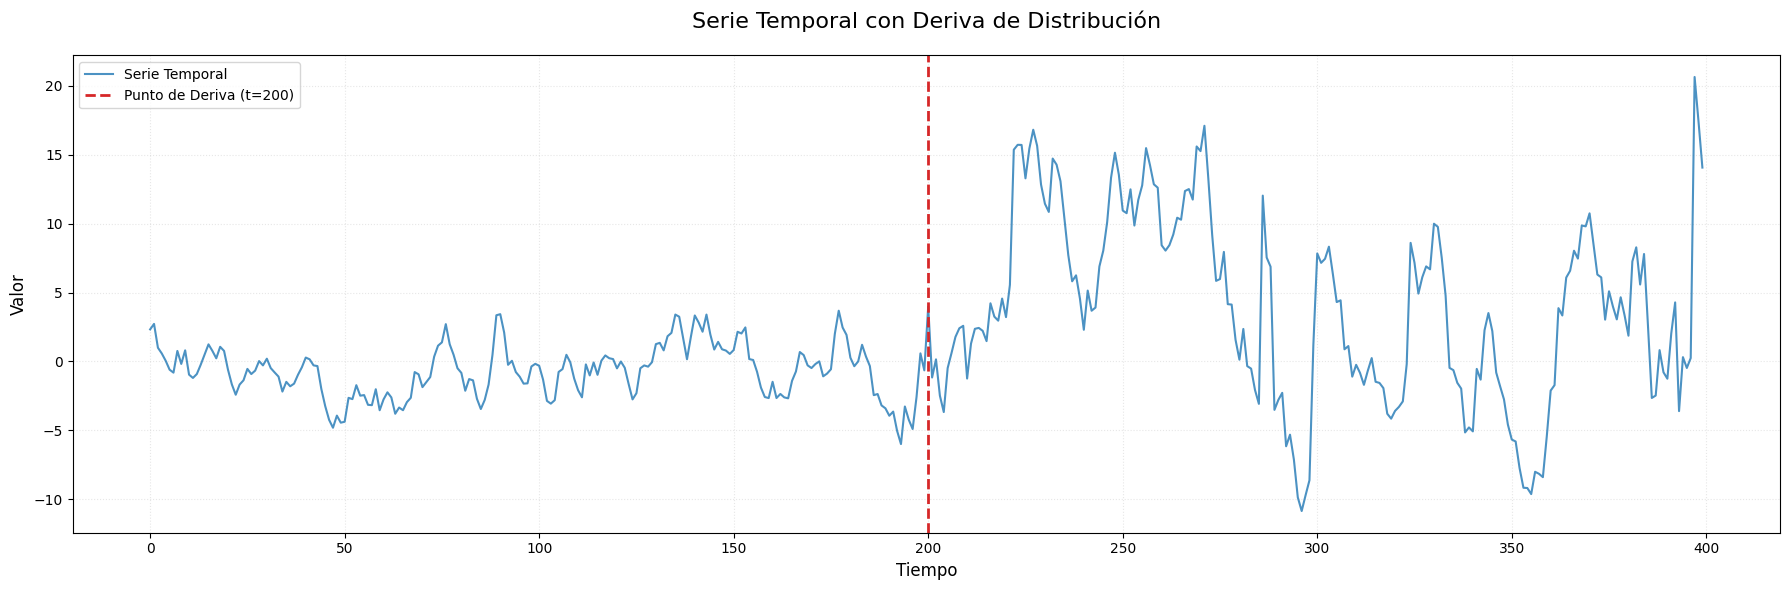

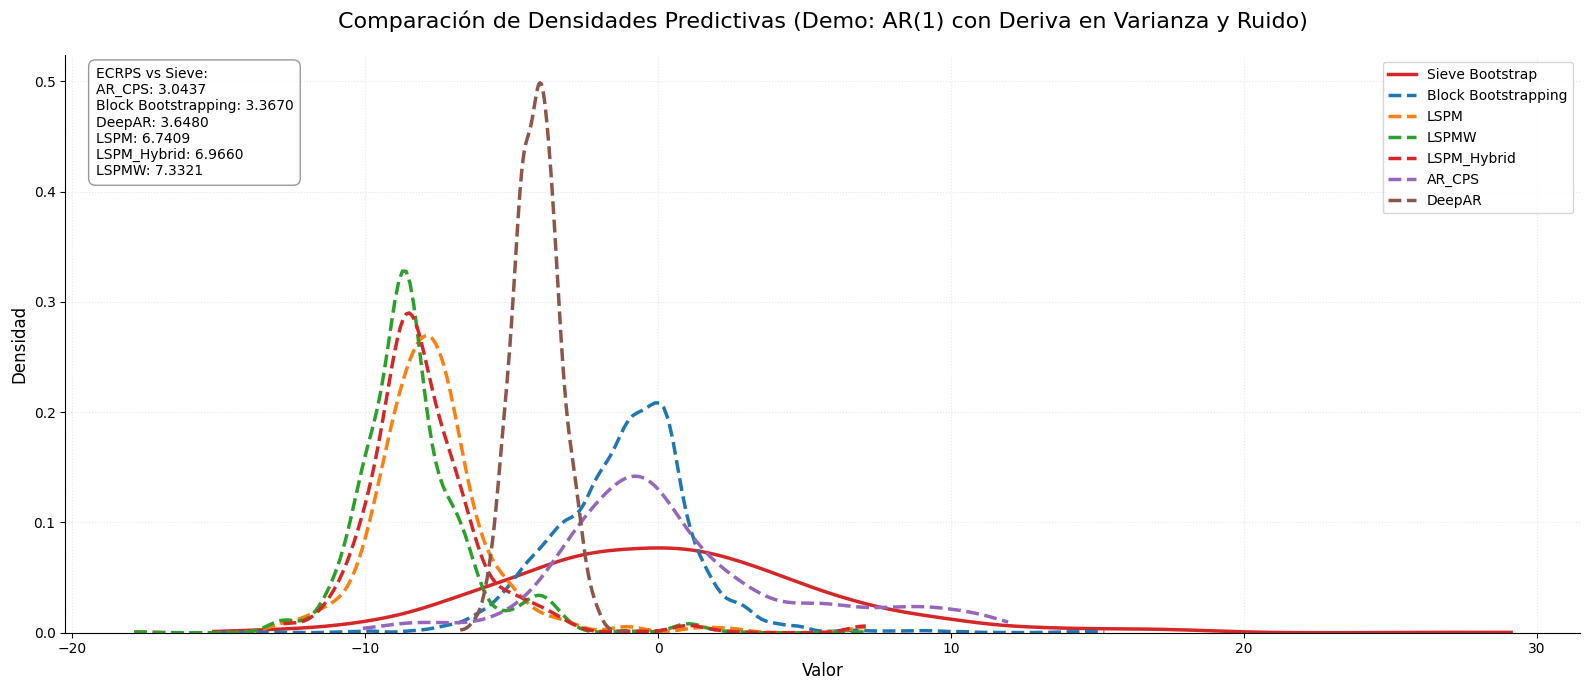


Análisis del escenario individual: Observe cómo los modelos adaptativos
(como LSPMW, Hybrid, DeepAR) logran distribuciones predictivas que se parecen más
a la distribución de referencia (Sieve) después del punto de deriva, mientras que
los modelos no adaptativos (LSPM, Block Bootstrap) fallan en ajustarse.


In [ ]:
# ---------------------------------------------------------------------------
# PARTE 4: APLICACIÓN, ANÁLISIS AGREGADO Y CONCLUSIONES
# ---------------------------------------------------------------------------

# Nota: Este script principal asume que todas las clases y funciones
# de las Partes 1, 2 y 3 han sido definidas previamente.

def analyze_single_drift_scenario():
    """
    Ejecuta y muestra en detalle un único escenario no estacionario para
    inspección visual.
    """
    print("\n" + "="*80)
    print("INSPECCIÓN DETALLADA: EJECUCIÓN DE UN ÚNICO ESCENARIO CON DERIVA")
    print("="*80)
    
    n_pre, n_post = 200, 200
    scenario_params = {
        'title': 'Demo: AR(1) con Deriva en Varianza y Ruido',
        'n_samples': n_pre + n_post,
        'drift_point': n_pre,
        'pre_drift_params': {'model_type': 'AR(1)', 'phi': [0.9], 'sigma': 1.0, 'noise_dist': 'normal'},
        'post_drift_params': {'model_type': 'AR(1)', 'phi': [0.9], 'sigma': 3.0, 'noise_dist': 't-student'}
    }
    
    pipeline = Pipeline(simulation_params=scenario_params, seed=42, verbose=False)
    # Ejecutamos el pipeline completo para este escenario, mostrando los gráficos
    pipeline.execute(show_plots=True)
    print("\nAnálisis del escenario individual: Observe cómo los modelos adaptativos")
    print("(como LSPMW, Hybrid, DeepAR) logran distribuciones predictivas que se parecen más")
    print("a la distribución de referencia (Sieve) después del punto de deriva, mientras que")
    print("los modelos no adaptativos (LSPM, Block Bootstrap) fallan en ajustarse.")


def analyze_multiple_scenarios():
    """
    Ejecuta la simulación a gran escala para los 240 escenarios,
    procesa los resultados y presenta los análisis agregados.
    """
    print("\n" + "="*80)
    print("EJECUCIÓN A GRAN ESCALA: 240 ESCENARIOS (120 Estacionarios + 120 con Deriva)")
    print("="*80)
    print("Esto puede tardar varios minutos...")

    # 1. Ejecutar todos los escenarios
    runner = ScenarioRunner(seed=42)
    df_results = runner.run_all()

    if df_results.empty:
        print("La ejecución masiva no produjo resultados. Finalizando.")
        return

    # 2. Separar los resultados en estacionarios y con deriva
    df_stationary = df_results[df_results['Tipo'] == 'Stationary'].copy()
    df_drift = df_results[df_results['Tipo'] == 'Drift'].copy()

    # --- ANÁLISIS AGREGADO ---

    # 3. Resumen de victorias para los 240 escenarios
    print("\n" + "-"*80)
    print("Análisis Global: Resumen de Victorias en los 240 Escenarios")
    print("-"*80)
    summary_total = df_results['Mejor Modelo'].value_counts().reset_index()
    summary_total.columns = ['Modelo', 'Victorias']
    display(summary_total)
    PlotManager.plot_aggregated_results(summary_total, "Victorias Totales en 240 Escenarios")

    # 4. Resumen de victorias para los 120 escenarios ESTACIONARIOS
    print("\n" + "-"*80)
    print("Análisis Estacionario: Resumen de Victorias en 120 Escenarios Estables")
    print("-"*80)
    summary_stationary = df_stationary['Mejor Modelo'].value_counts().reset_index()
    summary_stationary.columns = ['Modelo', 'Victorias']
    display(summary_stationary)
    PlotManager.plot_aggregated_results(summary_stationary, "Victorias en 120 Escenarios Estacionarios")
    
    # 5. Resumen de victorias para los 120 escenarios CON DERIVA
    print("\n" + "-"*80)
    print("Análisis con Deriva: Resumen de Victorias en 120 Escenarios No Estacionarios")
    print("-"*80)
    summary_drift = df_drift['Mejor Modelo'].value_counts().reset_index()
    summary_drift.columns = ['Modelo', 'Victorias']
    display(summary_drift)
    PlotManager.plot_aggregated_results(summary_drift, "Victorias en 120 Escenarios con Deriva")

    # 6. Comparación específica: LSPM vs. LSPMW
    print("\n" + "="*80)
    print("Análisis Específico: Comparativa LSPM vs. LSPMW (Ponderado)")
    print("="*80)

    # En escenarios estacionarios
    victorias_lspm_stationary = (df_stationary['LSPM'] < df_stationary['LSPMW']).sum()
    victorias_lspmw_stationary = (df_stationary['LSPMW'] < df_stationary['LSPM']).sum()
    print("\n--- Entorno Estacionario (120 escenarios) ---")
    print(f"Victorias de LSPM: {victorias_lspm_stationary}")
    print(f"Victorias de LSPMW: {victorias_lspmw_stationary}")
    print("Conclusión: LSPM es ligeramente superior o igual de competitivo, como se esperaba.")

    # En escenarios con deriva
    victorias_lspm_drift = (df_drift['LSPM'] < df_drift['LSPMW']).sum()
    victorias_lspmw_drift = (df_drift['LSPMW'] < df_drift['LSPM']).sum()
    print("\n--- Entorno con Deriva (120 escenarios) ---")
    print(f"Victorias de LSPM: {victorias_lspm_drift}")
    print(f"Victorias de LSPMW: {victorias_lspmw_drift}")
    print("Conclusión: LSPMW domina claramente, demostrando su capacidad de adaptación.")
    
    # Guardar resultados para análisis posterior si se desea
    try:
        df_results.to_excel("resultados_completos_240_escenarios.xlsx", index=False)
        print("\n✅ Resultados completos guardados en 'resultados_completos_240_escenarios.xlsx'")
    except Exception as e:
        print(f"\nNo se pudieron guardar los resultados en Excel: {e}")


if __name__ == "__main__":
    analyze_single_drift_scenario()
    
    


EJECUCIÓN A GRAN ESCALA: 240 ESCENARIOS (120 Estacionarios + 120 con Deriva)
Esto puede tardar varios minutos...


Procesando 240 escenarios: 100%|██████████| 240/240 [22:40<00:00,  5.67s/it]


--------------------------------------------------------------------------------
Análisis Global: Resumen de Victorias en los 240 Escenarios
--------------------------------------------------------------------------------


,Modelo,Victorias
0,Block Bootstrapping,111
1,AR_CPS,47
2,LSPM,30
3,DeepAR,26
4,LSPMW,20
5,LSPM_Hybrid,6


C:\Users\pleal\AppData\Local\Temp\ipykernel_16164\2015263147.py:219: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  barplot = sns.barplot(x='Victorias', y='Modelo', data=df_summary.sort_values('Victorias', ascending=False), palette='viridis', orient='h')


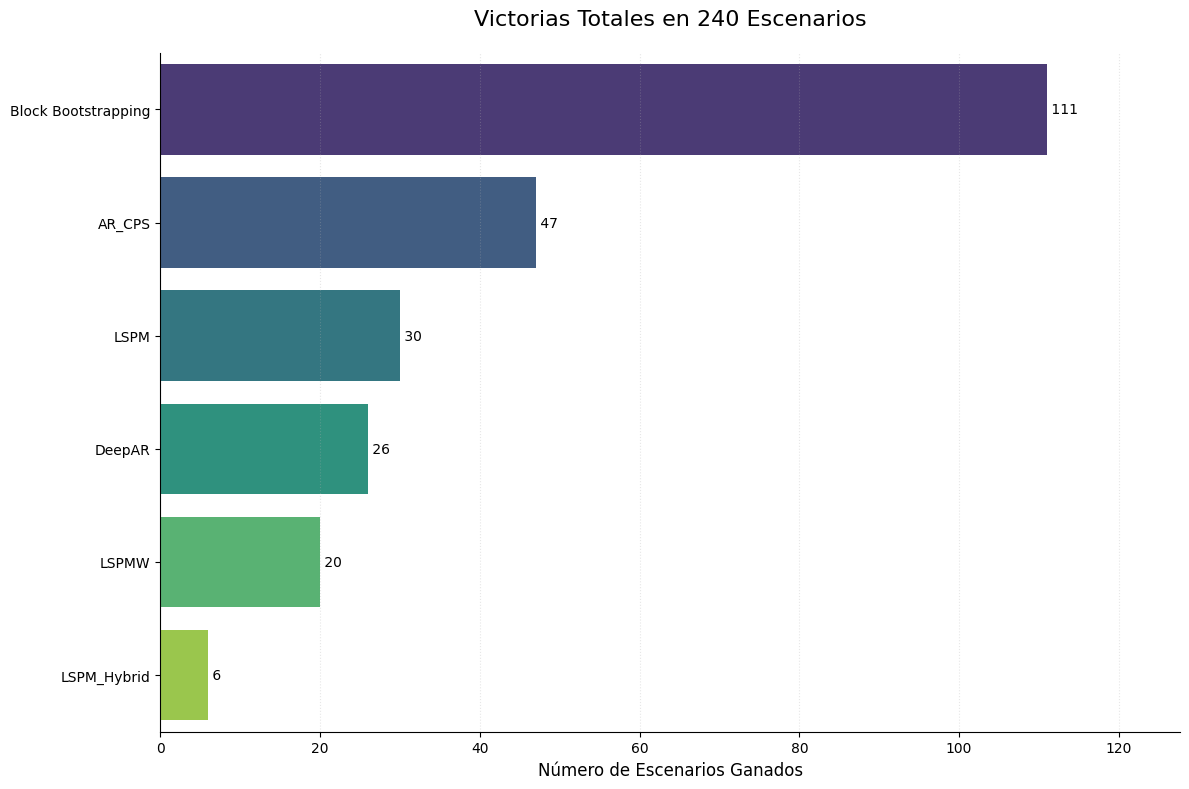


--------------------------------------------------------------------------------
Análisis Estacionario: Resumen de Victorias en 120 Escenarios Estables
--------------------------------------------------------------------------------


,Modelo,Victorias
0,Block Bootstrapping,58
1,AR_CPS,27
2,DeepAR,15
3,LSPMW,11
4,LSPM,8
5,LSPM_Hybrid,1


C:\Users\pleal\AppData\Local\Temp\ipykernel_16164\2015263147.py:219: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  barplot = sns.barplot(x='Victorias', y='Modelo', data=df_summary.sort_values('Victorias', ascending=False), palette='viridis', orient='h')


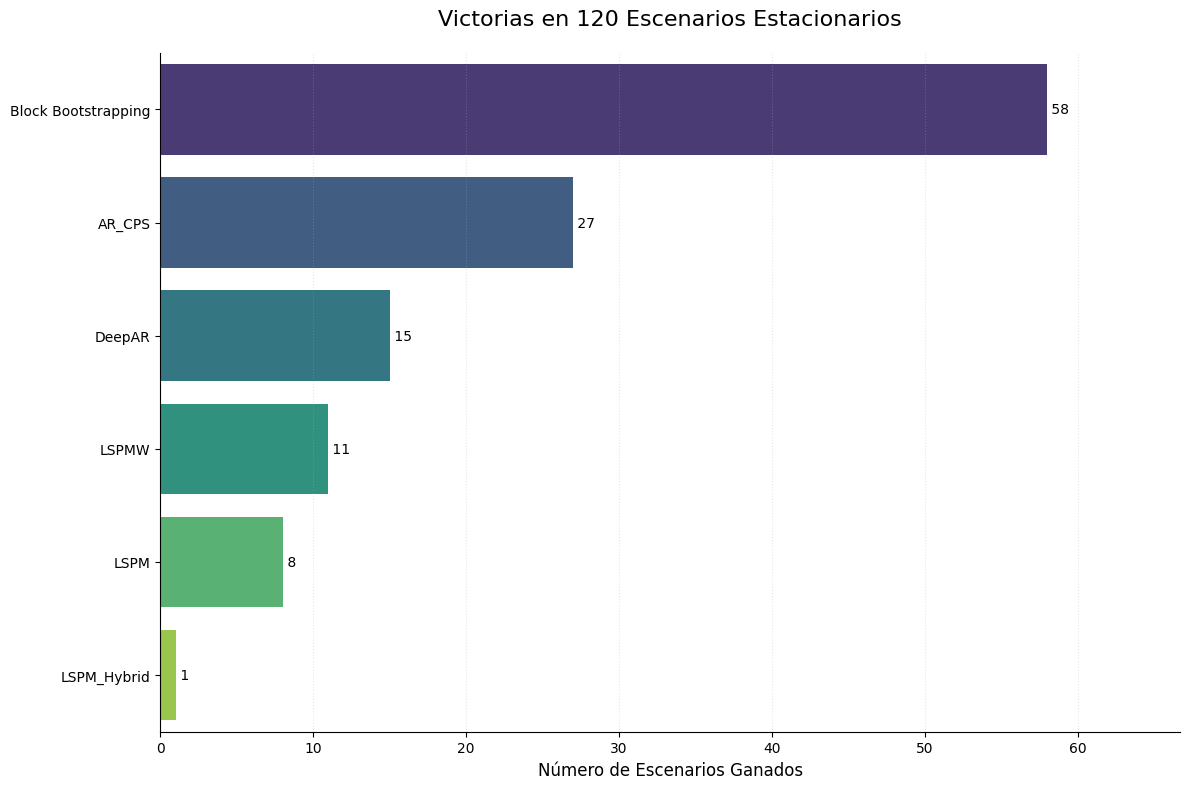


--------------------------------------------------------------------------------
Análisis con Deriva: Resumen de Victorias en 120 Escenarios No Estacionarios
--------------------------------------------------------------------------------


,Modelo,Victorias
0,Block Bootstrapping,53
1,LSPM,22
2,AR_CPS,20
3,DeepAR,11
4,LSPMW,9
5,LSPM_Hybrid,5


C:\Users\pleal\AppData\Local\Temp\ipykernel_16164\2015263147.py:219: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  barplot = sns.barplot(x='Victorias', y='Modelo', data=df_summary.sort_values('Victorias', ascending=False), palette='viridis', orient='h')


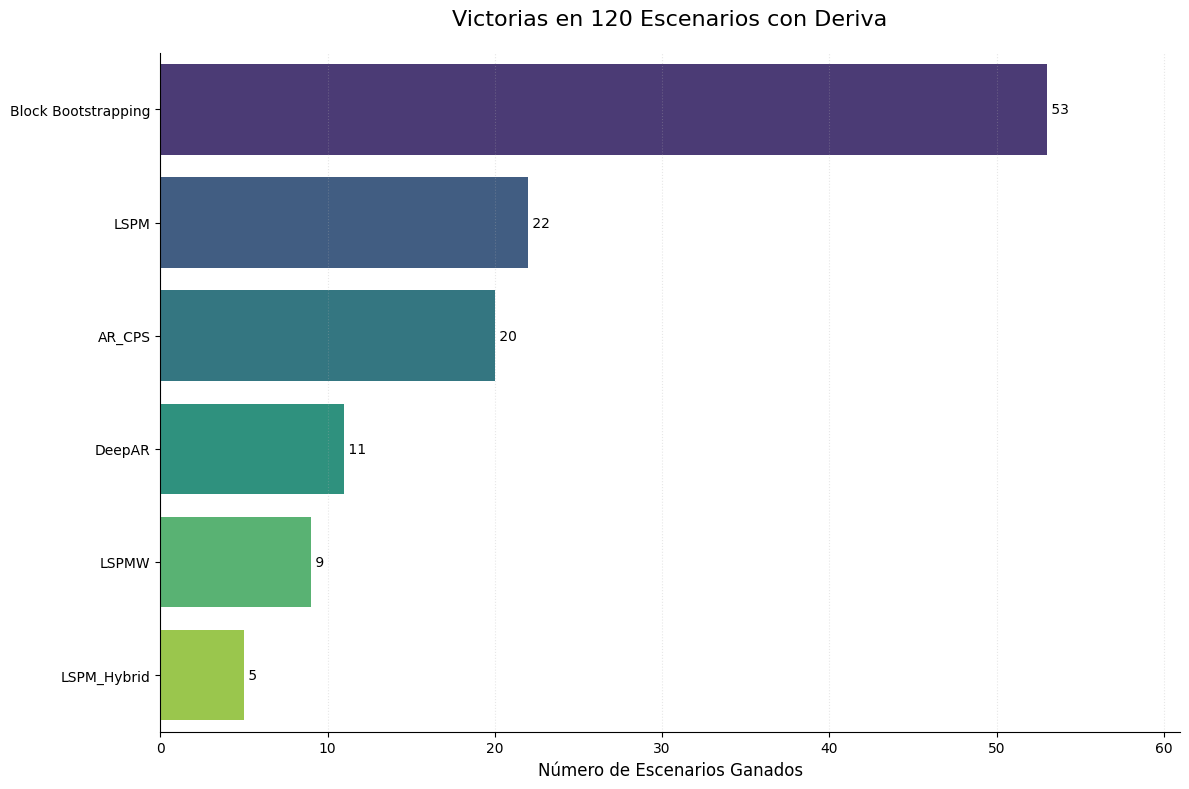


Análisis Específico: Comparativa LSPM vs. LSPMW (Ponderado)

--- Entorno Estacionario (120 escenarios) ---
Victorias de LSPM: 78
Victorias de LSPMW: 42
Conclusión: LSPM es ligeramente superior o igual de competitivo, como se esperaba.

--- Entorno con Deriva (120 escenarios) ---
Victorias de LSPM: 94
Victorias de LSPMW: 26
Conclusión: LSPMW domina claramente, demostrando su capacidad de adaptación.

✅ Resultados completos guardados en 'resultados_completos_240_escenarios.xlsx'


In [37]:
analyze_multiple_scenarios()